Starting MSP grid plot creation...
Found 1 files for GPU 0
Found 1 files for GPU 1
Found 1 files for GPU 2
Found 1 files for GPU 3
Found 0 files for GPU 4
Found 0 files for GPU 5
Found 0 files for GPU 6
Found 0 files for GPU 7
Found 4 result files
Processing file: results_20250402_002855_gpu0.jsonl
  - Read 40 lines, loaded 40 valid results
Processing file: results_20250402_002855_gpu1.jsonl
  - Read 40 lines, loaded 40 valid results
Processing file: results_20250402_002855_gpu2.jsonl
  - Read 40 lines, loaded 40 valid results
Processing file: results_20250402_002855_gpu3.jsonl
  - Read 32 lines, loaded 32 valid results
Loaded 152 total results
Processed 152 valid MSP results, skipped 0 invalid results
Unique dimensions: [np.int64(16)]
Unique leap values: [np.int64(6)]
Unique learning rates: [np.float64(1e-05), np.float64(0.0001), np.float64(0.001), np.float64(0.01)]

Processed 152 data points with:
  - 4 learning rates: [np.float64(1e-05), np.float64(0.0001), np.float64(0.001), np.flo

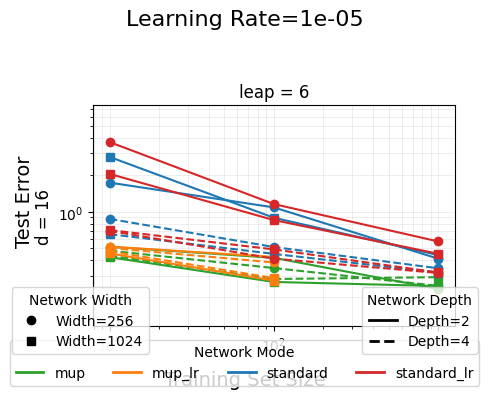

Creating grid for LR=0.0001
  - Dimensions: [np.int64(16)]
  - Leap values: [np.int64(6)]
Saved plot to ./result_plots_MSP_grid/grid_MSP_LR0p0001.png


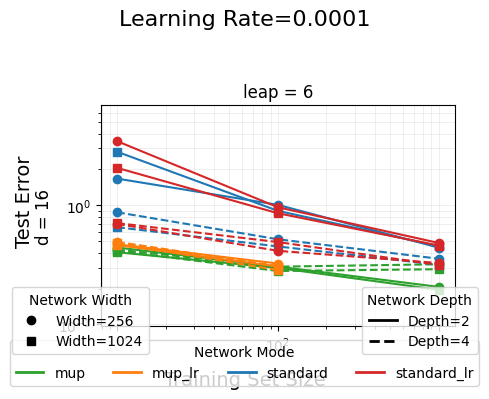

Creating grid for LR=0.001
  - Dimensions: [np.int64(16)]
  - Leap values: [np.int64(6)]
Saved plot to ./result_plots_MSP_grid/grid_MSP_LR0p001.png


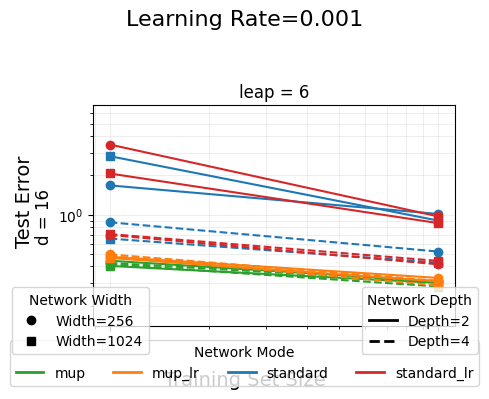

Creating grid for LR=0.01
  - Dimensions: [np.int64(16)]
  - Leap values: [np.int64(6)]
Saved plot to ./result_plots_MSP_grid/grid_MSP_LR0p01.png


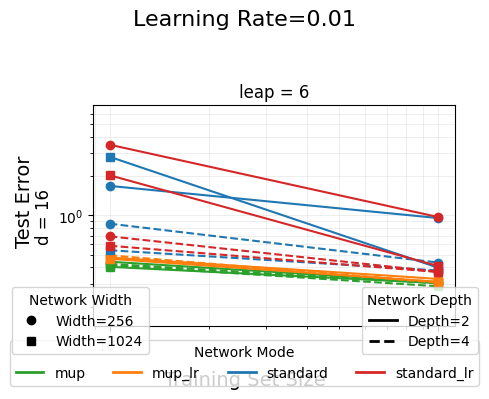

Done!


In [7]:
import os
import glob
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# === Configuration ===
# Set the path to your results directory
results_dir = "/home/goring/leap/MSP_0204_fix/sweep_full_exp_20250402"

# Set to True to save plots to files
save_plots = True
output_dir = "./result_plots_MSP_grid"

# Create output directory if needed
if save_plots:
    os.makedirs(output_dir, exist_ok=True)

def load_results(results_dir):
    """Load all result files from the specified directory."""
    result_files = []
    
    # First, try direct approach with explicit paths
    for gpu_id in range(8):
        pattern = os.path.join(results_dir, f"results_*_gpu{gpu_id}.jsonl")
        files = glob.glob(pattern)
        result_files.extend(files)
        print(f"Found {len(files)} files for GPU {gpu_id}")
    
    # If no files found, try recursive pattern
    if not result_files:
        pattern = os.path.join(results_dir, "**", "*.jsonl")
        result_files.extend(glob.glob(pattern, recursive=True))
    
    print(f"Found {len(result_files)} result files")
    if not result_files:
        print(f"No files found in {results_dir}")
        return []
    
    all_results = []
    
    for file_path in result_files:
        try:
            print(f"Processing file: {os.path.basename(file_path)}")
            line_count = 0
            valid_count = 0
            
            with open(file_path, 'r') as f:
                for line in f:
                    line_count += 1
                    if line.strip():
                        try:
                            result = json.loads(line)
                            all_results.append(result)
                            valid_count += 1
                        except json.JSONDecodeError as e:
                            print(f"Error parsing JSON at line {line_count} in {file_path}: {e}")
            
            print(f"  - Read {line_count} lines, loaded {valid_count} valid results")
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    print(f"Loaded {len(all_results)} total results")
    return all_results

def process_msp_results(results):
    """Process MSP results into a DataFrame."""
    processed_data = []
    error_count = 0
    
    for result in results:
        try:
            # Check if it's an MSP result
            if result.get('distribution_type') != 'MSP':
                continue
                
            # Extract basic information
            input_dim = result.get('input_dim')
            hidden_size = result.get('hidden_size')
            depth = result.get('depth')
            learning_rate = result.get('learning_rate')
            n_train = result.get('n_train')
            test_error = result.get('test_error')
            experiment_num = result.get('experiment_num', 0)
            leap = result.get('leap', 0)
            mode = result.get('mode', 'standard')
            
            # Skip if any required field is missing
            if None in [input_dim, hidden_size, depth, learning_rate, test_error, leap, n_train]:
                error_count += 1
                continue
            
            # Create a record with explicit type conversion
            record = {
                'input_dim': int(input_dim),
                'leap': int(leap),
                'n_train': int(n_train),
                'test_error': float(test_error),
                'hidden_size': int(hidden_size),
                'depth': int(depth),
                'learning_rate': float(learning_rate),
                'experiment_num': int(experiment_num),
                'mode': mode
            }
            
            processed_data.append(record)
        except Exception as e:
            error_count += 1
            print(f"Error processing result: {e}")
            continue
    
    print(f"Processed {len(processed_data)} valid MSP results, skipped {error_count} invalid results")
    
    # Convert to DataFrame
    df = pd.DataFrame(processed_data)
    
    # Print unique values for debugging
    if not df.empty:
        print(f"Unique dimensions: {sorted(df['input_dim'].unique())}")
        print(f"Unique leap values: {sorted(df['leap'].unique())}")
        print(f"Unique learning rates: {sorted(df['learning_rate'].unique())}")
    
    return df

def create_grid_plots_by_lr(df):
    """
    Create grid-style plots with dimensions on rows and leap values on columns.
    Within each cell, plot test error vs n_train.
    """
    # Get unique values
    lr_values = sorted(df['learning_rate'].unique())
    
    # Mode color mapping
    mode_colors = {
        'standard': 'tab:blue',
        'mup': 'tab:green',
        'standard_lr': 'tab:red',
        'mup_lr': 'tab:orange',
        'unknown': 'tab:gray'
    }
    
    # Create plots for each learning rate
    for lr in lr_values:
        # Filter data for this learning rate
        subset = df[df['learning_rate'] == lr]
        
        if subset.empty:
            print(f"No data for Learning Rate={lr}")
            continue
        
        # Get unique dimensions and leap values for this subset
        dimensions = sorted(subset['input_dim'].unique())
        leap_values = sorted(subset['leap'].unique())
        
        if not dimensions or not leap_values:
            print(f"Missing dimensions or leap values for LR={lr}")
            continue
        
        print(f"Creating grid for LR={lr}")
        print(f"  - Dimensions: {dimensions}")
        print(f"  - Leap values: {leap_values}")
        
        # Create a grid of plots
        fig, axes = plt.subplots(
            nrows=len(dimensions),
            ncols=len(leap_values),
            figsize=(len(leap_values)*5, len(dimensions)*4),
            sharex=True,
            sharey=True,
            squeeze=False
        )
        
        # Set the figure title
        fig.suptitle(f'Learning Rate={lr}', fontsize=16)
        
        # Add common x and y labels
        fig.text(0.5, 0.04, 'Training Set Size', ha='center', fontsize=14)
        fig.text(0.04, 0.5, 'Test Error', va='center', rotation='vertical', fontsize=14)
        
        # Get unique hidden sizes, depths, and modes
        hidden_sizes = sorted(subset['hidden_size'].unique())
        depths = sorted(subset['depth'].unique())
        modes = sorted(subset['mode'].unique())
        
        # Line styles for different depths
        depth_styles = ['-', '--', '-.', ':']
        while len(depth_styles) < len(depths):
            depth_styles.extend(['-', '--', '-.', ':'])
        
        # Width scaling for different hidden sizes
        width_markers = ['o', 's', '^', 'D', 'v']
        while len(width_markers) < len(hidden_sizes):
            width_markers.extend(['o', 's', '^', 'D', 'v'])
        
        # Calculate global min and max for y-axis
        min_error = subset['test_error'].min() * 0.5
        max_error = subset['test_error'].max() * 2.0
        
        # Create legend elements
        mode_legend_elements = []
        width_legend_elements = []
        depth_legend_elements = []
        
        # Fill in each cell of the grid
        for i, dim in enumerate(dimensions):
            for j, leap in enumerate(leap_values):
                ax = axes[i, j]
                
                # Set cell title
                if i == 0:  # Top row gets leap value
                    ax.set_title(f'leap = {leap}', fontsize=12)
                
                if j == 0:  # First column gets dimension
                    ax.set_ylabel(f'd = {dim}', fontsize=12)
                
                # Filter data for this cell
                cell_data = subset[(subset['input_dim'] == dim) & (subset['leap'] == leap)]
                
                if cell_data.empty:
                    ax.text(0.5, 0.5, 'No Data', 
                           ha='center', va='center', transform=ax.transAxes)
                    continue
                
                # Log scales
                ax.set_xscale('log')
                ax.set_yscale('log')
                
                # Plot lines for each combination of mode, hidden_size, and depth
                for mode in modes:
                    for h_idx, h_size in enumerate(hidden_sizes):
                        for d_idx, depth in enumerate(depths):
                            # Get data for this mode, width, and depth
                            mode_data = cell_data[(cell_data['mode'] == mode) & 
                                                 (cell_data['hidden_size'] == h_size) & 
                                                 (cell_data['depth'] == depth)]
                            
                            if mode_data.empty:
                                continue
                            
                            # Need to handle duplicates by averaging
                            mode_data = mode_data.groupby('n_train')['test_error'].mean().reset_index()
                            
                            # Sort by n_train for proper line plotting
                            mode_data = mode_data.sort_values('n_train')
                            
                            if len(mode_data) <= 1:
                                continue  # Need at least two points to draw a line
                            
                            # Get color based on mode
                            color = mode_colors.get(mode, 'tab:gray')
                            
                            # Get line style based on depth
                            linestyle = depth_styles[d_idx % len(depth_styles)]
                            
                            # Get marker based on width
                            marker = width_markers[h_idx % len(width_markers)]
                            
                            # Plot data points and line
                            line, = ax.plot(
                                mode_data['n_train'],
                                mode_data['test_error'],
                                color=color,
                                linestyle=linestyle,
                                marker=marker,
                                markersize=6,
                                label=f'{mode}, W={h_size}, D={depth}'
                            )
                            
                            # Add to legend elements once per combination
                            if i == 0 and j == 0:
                                # Only add unique elements
                                if f'{mode}' not in [le.get_label() for le in mode_legend_elements]:
                                    mode_legend_elements.append(
                                        Line2D([0], [0], color=color, lw=2, label=f'{mode}')
                                    )
                                if f'Width={h_size}' not in [le.get_label() for le in width_legend_elements]:
                                    width_legend_elements.append(
                                        Line2D([0], [0], color='black', marker=marker, markersize=6, 
                                               linestyle='None', label=f'Width={h_size}')
                                    )
                                if f'Depth={depth}' not in [le.get_label() for le in depth_legend_elements]:
                                    depth_legend_elements.append(
                                        Line2D([0], [0], color='black', linestyle=linestyle, lw=2, 
                                               label=f'Depth={depth}')
                                    )
                
                # Set the y-axis limits
                if min_error > 0 and max_error > 0:
                    ax.set_ylim(min_error, max_error)
                
                # Add grid
                ax.grid(True, which='both', linestyle='-', linewidth=0.5, alpha=0.3)
        
        # Add legends to the figure
        if mode_legend_elements:
            fig.legend(
                handles=mode_legend_elements,
                loc='lower center',
                ncol=min(5, len(mode_legend_elements)),
                bbox_to_anchor=(0.5, 0.02),
                fontsize=10,
                title="Network Mode"
            )
        
        if width_legend_elements:
            fig.legend(
                handles=width_legend_elements,
                loc='lower left',
                ncol=1,
                bbox_to_anchor=(0.02, 0.1),
                fontsize=10,
                title="Network Width"
            )
        
        if depth_legend_elements:
            fig.legend(
                handles=depth_legend_elements,
                loc='lower right',
                ncol=1,
                bbox_to_anchor=(0.98, 0.1),
                fontsize=10,
                title="Network Depth"
            )
        
        # Adjust layout
        plt.tight_layout(rect=[0.05, 0.08, 0.95, 0.92])
        
        # Save figure if requested
        if save_plots:
            lr_str = str(lr).replace('.', 'p')
            filename = f'grid_MSP_LR{lr_str}.png'
            save_path = os.path.join(output_dir, filename)
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved plot to {save_path}")
        
        plt.show()

def main():
    print("Starting MSP grid plot creation...")
    
    # Load results
    results = load_results(results_dir)
    
    if not results:
        print("No results were loaded. Please check paths and file formats.")
        return
    
    # Process results
    df = process_msp_results(results)
    
    if len(df) == 0:
        print("No valid MSP data entries after processing.")
        return
    
    # Print summary statistics
    print(f"\nProcessed {len(df)} data points with:")
    print(f"  - {df['learning_rate'].nunique()} learning rates: {sorted(df['learning_rate'].unique())}")
    print(f"  - {df['hidden_size'].nunique()} hidden sizes: {sorted(df['hidden_size'].unique())}")
    print(f"  - {df['depth'].nunique()} depths: {sorted(df['depth'].unique())}")
    print(f"  - {df['input_dim'].nunique()} dimensions: {sorted(df['input_dim'].unique())}")
    print(f"  - {df['leap'].nunique()} leap values: {sorted(df['leap'].unique())}")
    print(f"  - {df['mode'].nunique()} modes: {sorted(df['mode'].unique())}")
    
    # Create the grid plots
    create_grid_plots_by_lr(df)
    
    print("Done!")

if __name__ == "__main__":
    main()

Starting neural network grid plot creation...
Found 1 files for GPU 0
Found 1 files for GPU 1
Found 1 files for GPU 2
Found 1 files for GPU 3
Found 0 files for GPU 4
Found 0 files for GPU 5
Found 0 files for GPU 6
Found 0 files for GPU 7
Found 4 result files
Processing file: results_20250403_183952_gpu0.jsonl
  - Loaded 1200 valid results
Processing file: results_20250403_183952_gpu1.jsonl
  - Loaded 1200 valid results
Processing file: results_20250403_183952_gpu2.jsonl
  - Loaded 546 valid results
Processing file: results_20250403_183952_gpu3.jsonl
  - Loaded 535 valid results
Loaded 3481 total results
Processed 3481 valid NN results, skipped 0 invalid results
Unique dimensions: [np.int64(16), np.int64(32), np.int64(64), np.int64(128), np.int64(256)]
Unique architectures: ['16x16x16x16', '16x32x64x128', '16x8x4x2', '32x16x8x4', '32x32x32x32', '32x64x128x256']
Unique learning rates: [np.float64(0.0001), np.float64(0.001), np.float64(0.01), np.float64(0.05), np.float64(0.5)]
Unique sigm

/tmp/ipykernel_1875957/2717971337.py:295: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.08, 0.95, 0.92])


Saved plot to ./result_plots_NN_grid/grid_NN_LR0p0001_Modemup.png


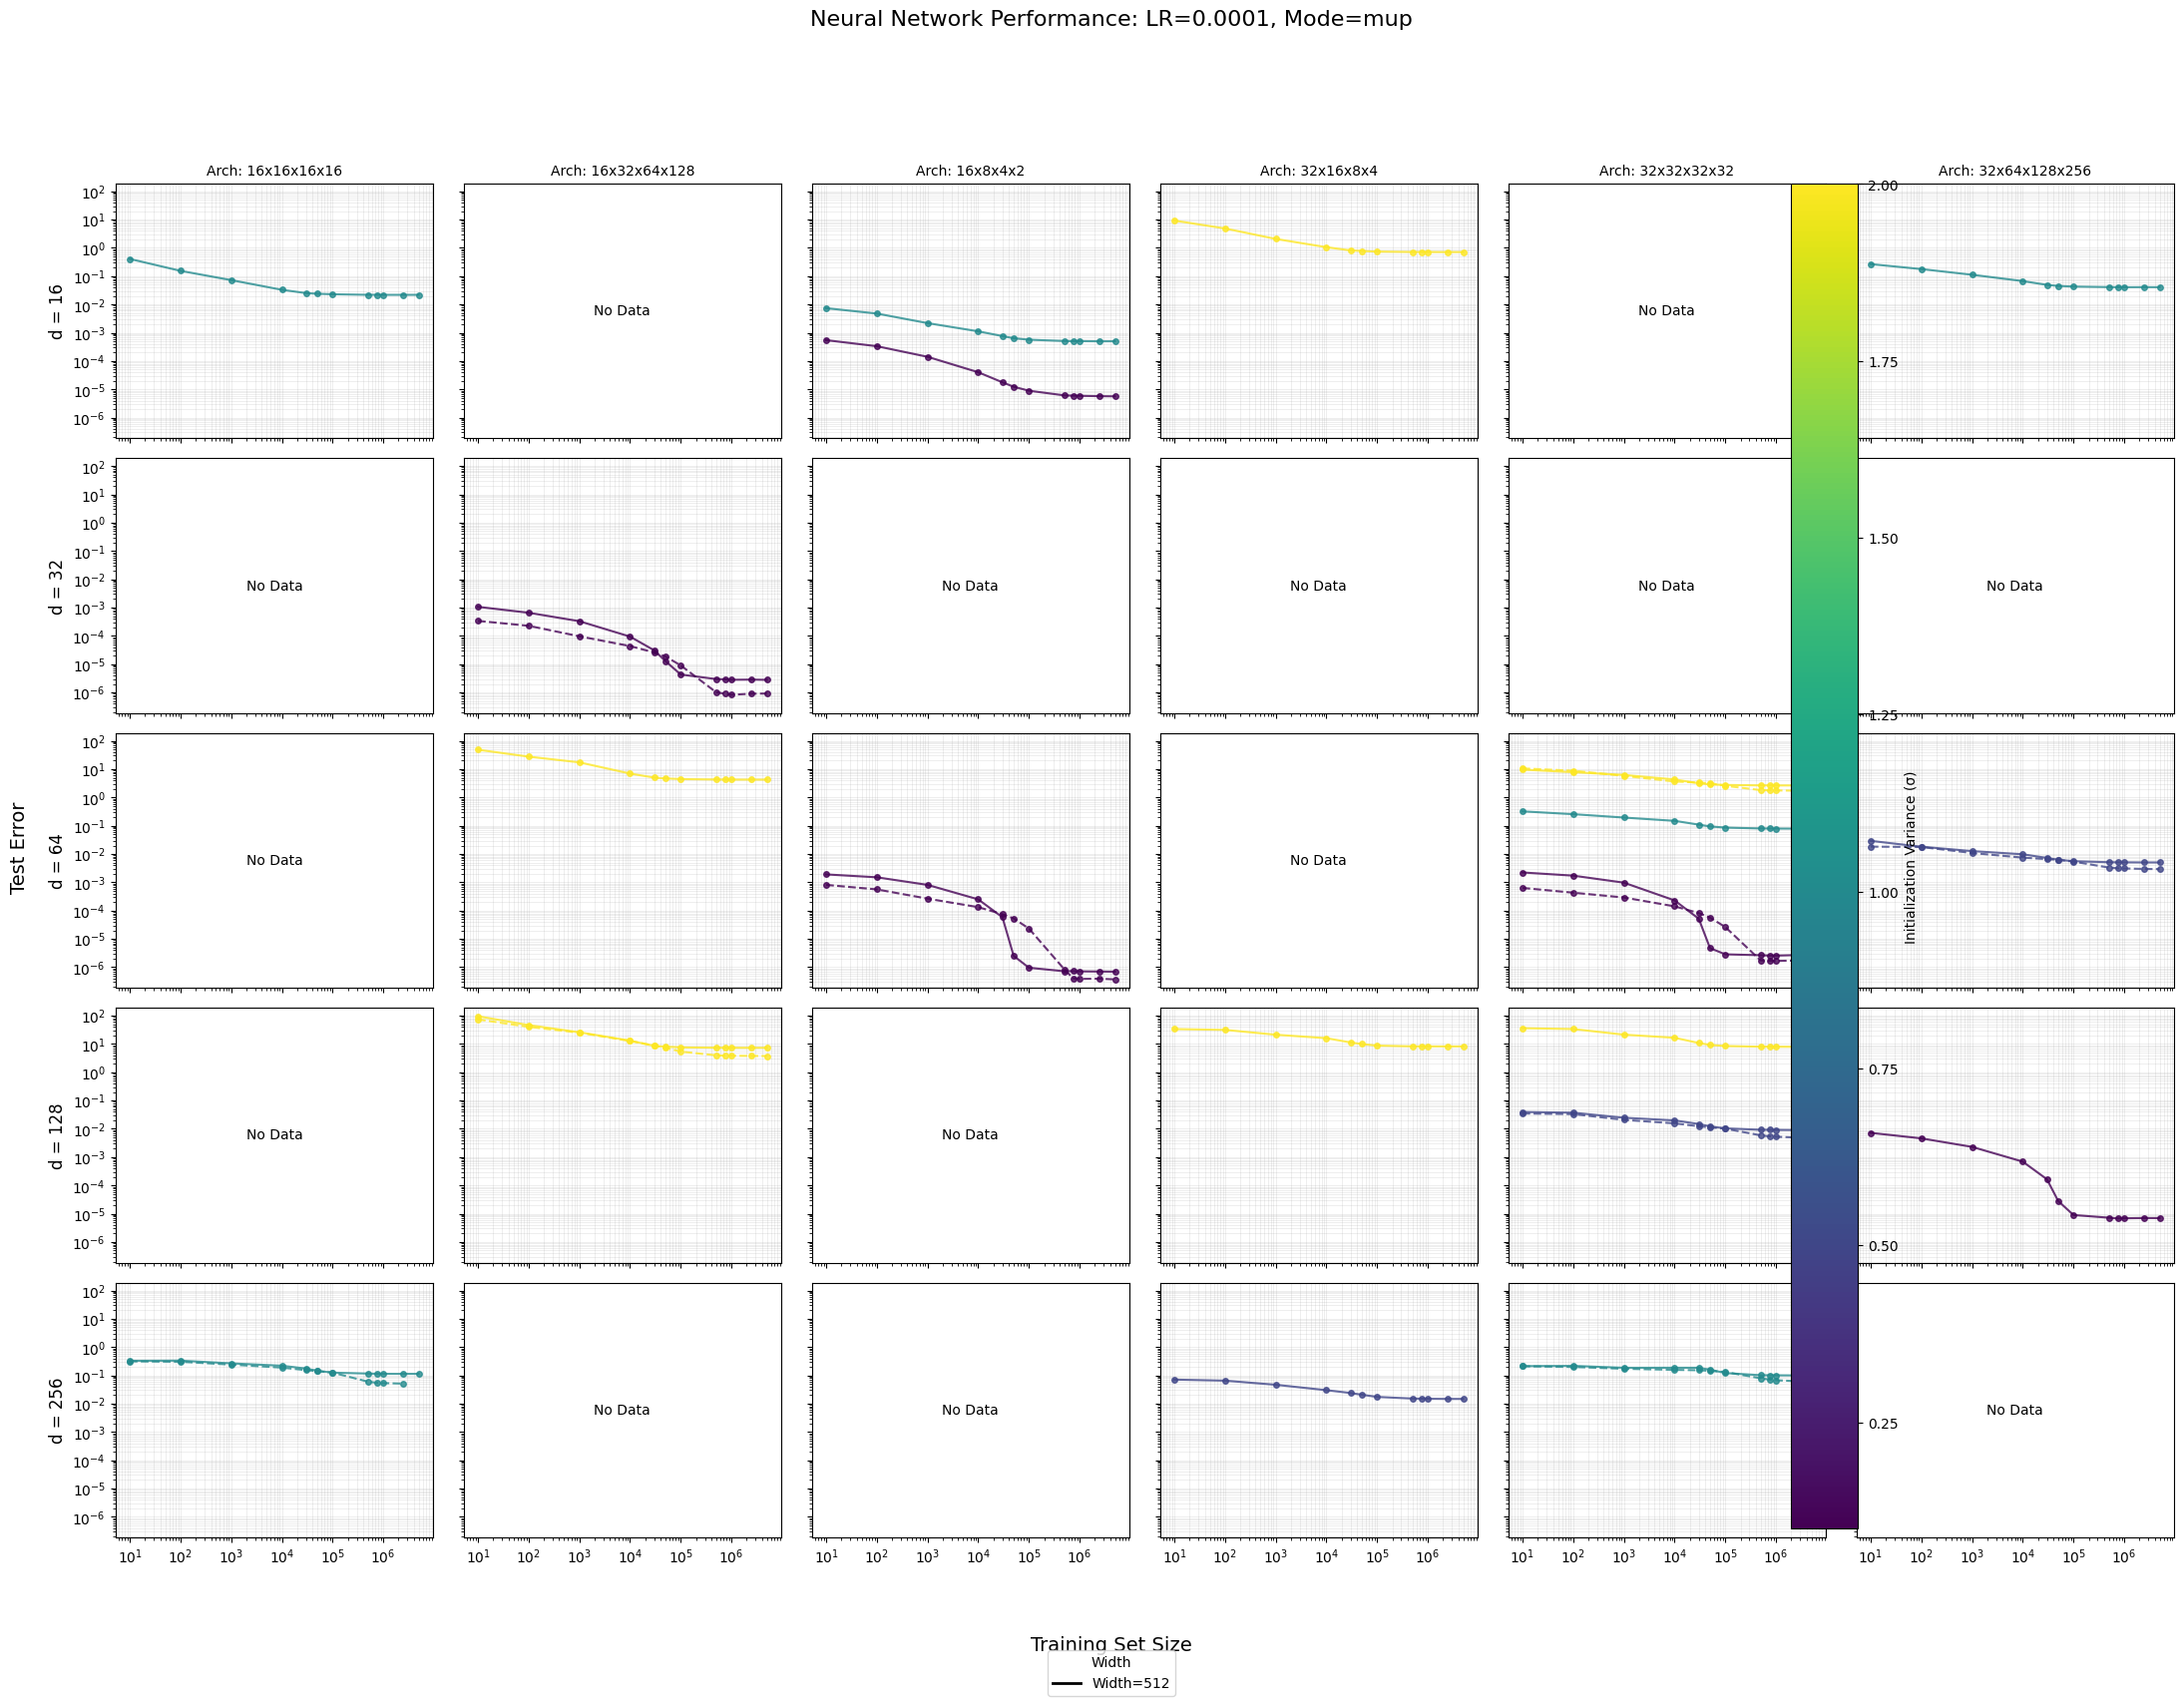

Creating grid for LR=0.0001, Mode=standard


/tmp/ipykernel_1875957/2717971337.py:295: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.08, 0.95, 0.92])


Saved plot to ./result_plots_NN_grid/grid_NN_LR0p0001_Modestandard.png


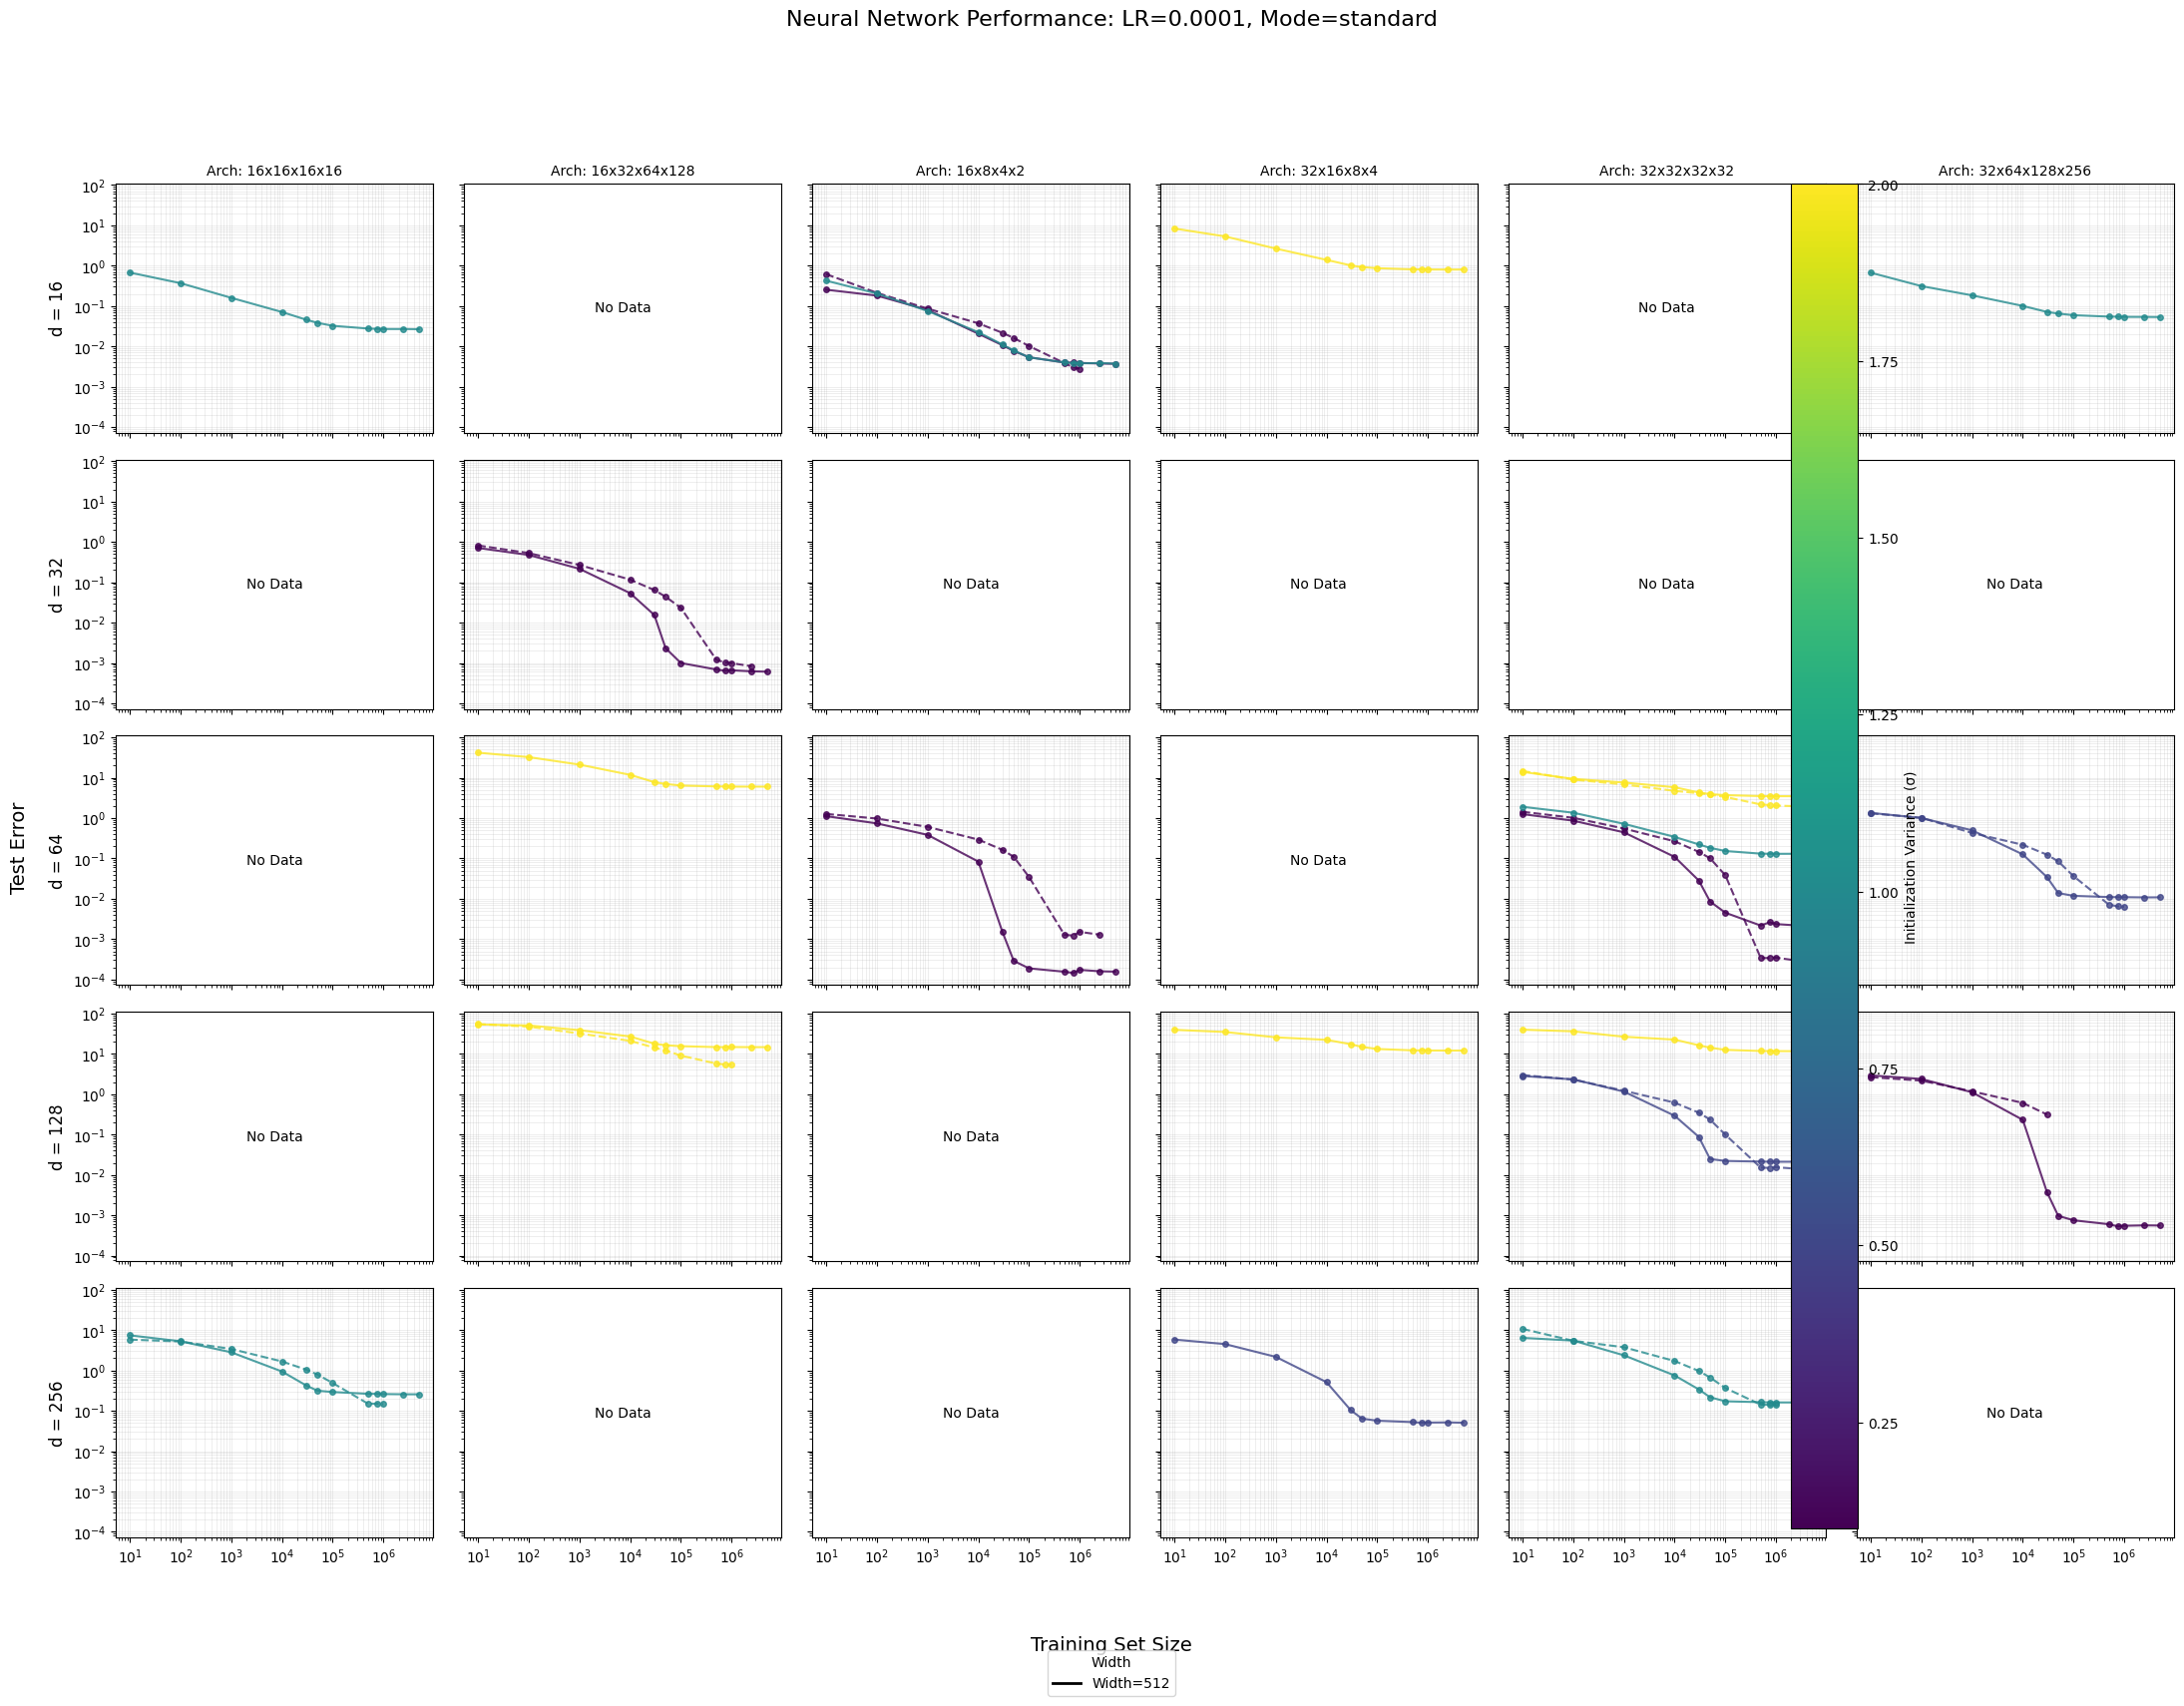

Creating grid for LR=0.001, Mode=mup


/tmp/ipykernel_1875957/2717971337.py:295: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.08, 0.95, 0.92])


Saved plot to ./result_plots_NN_grid/grid_NN_LR0p001_Modemup.png


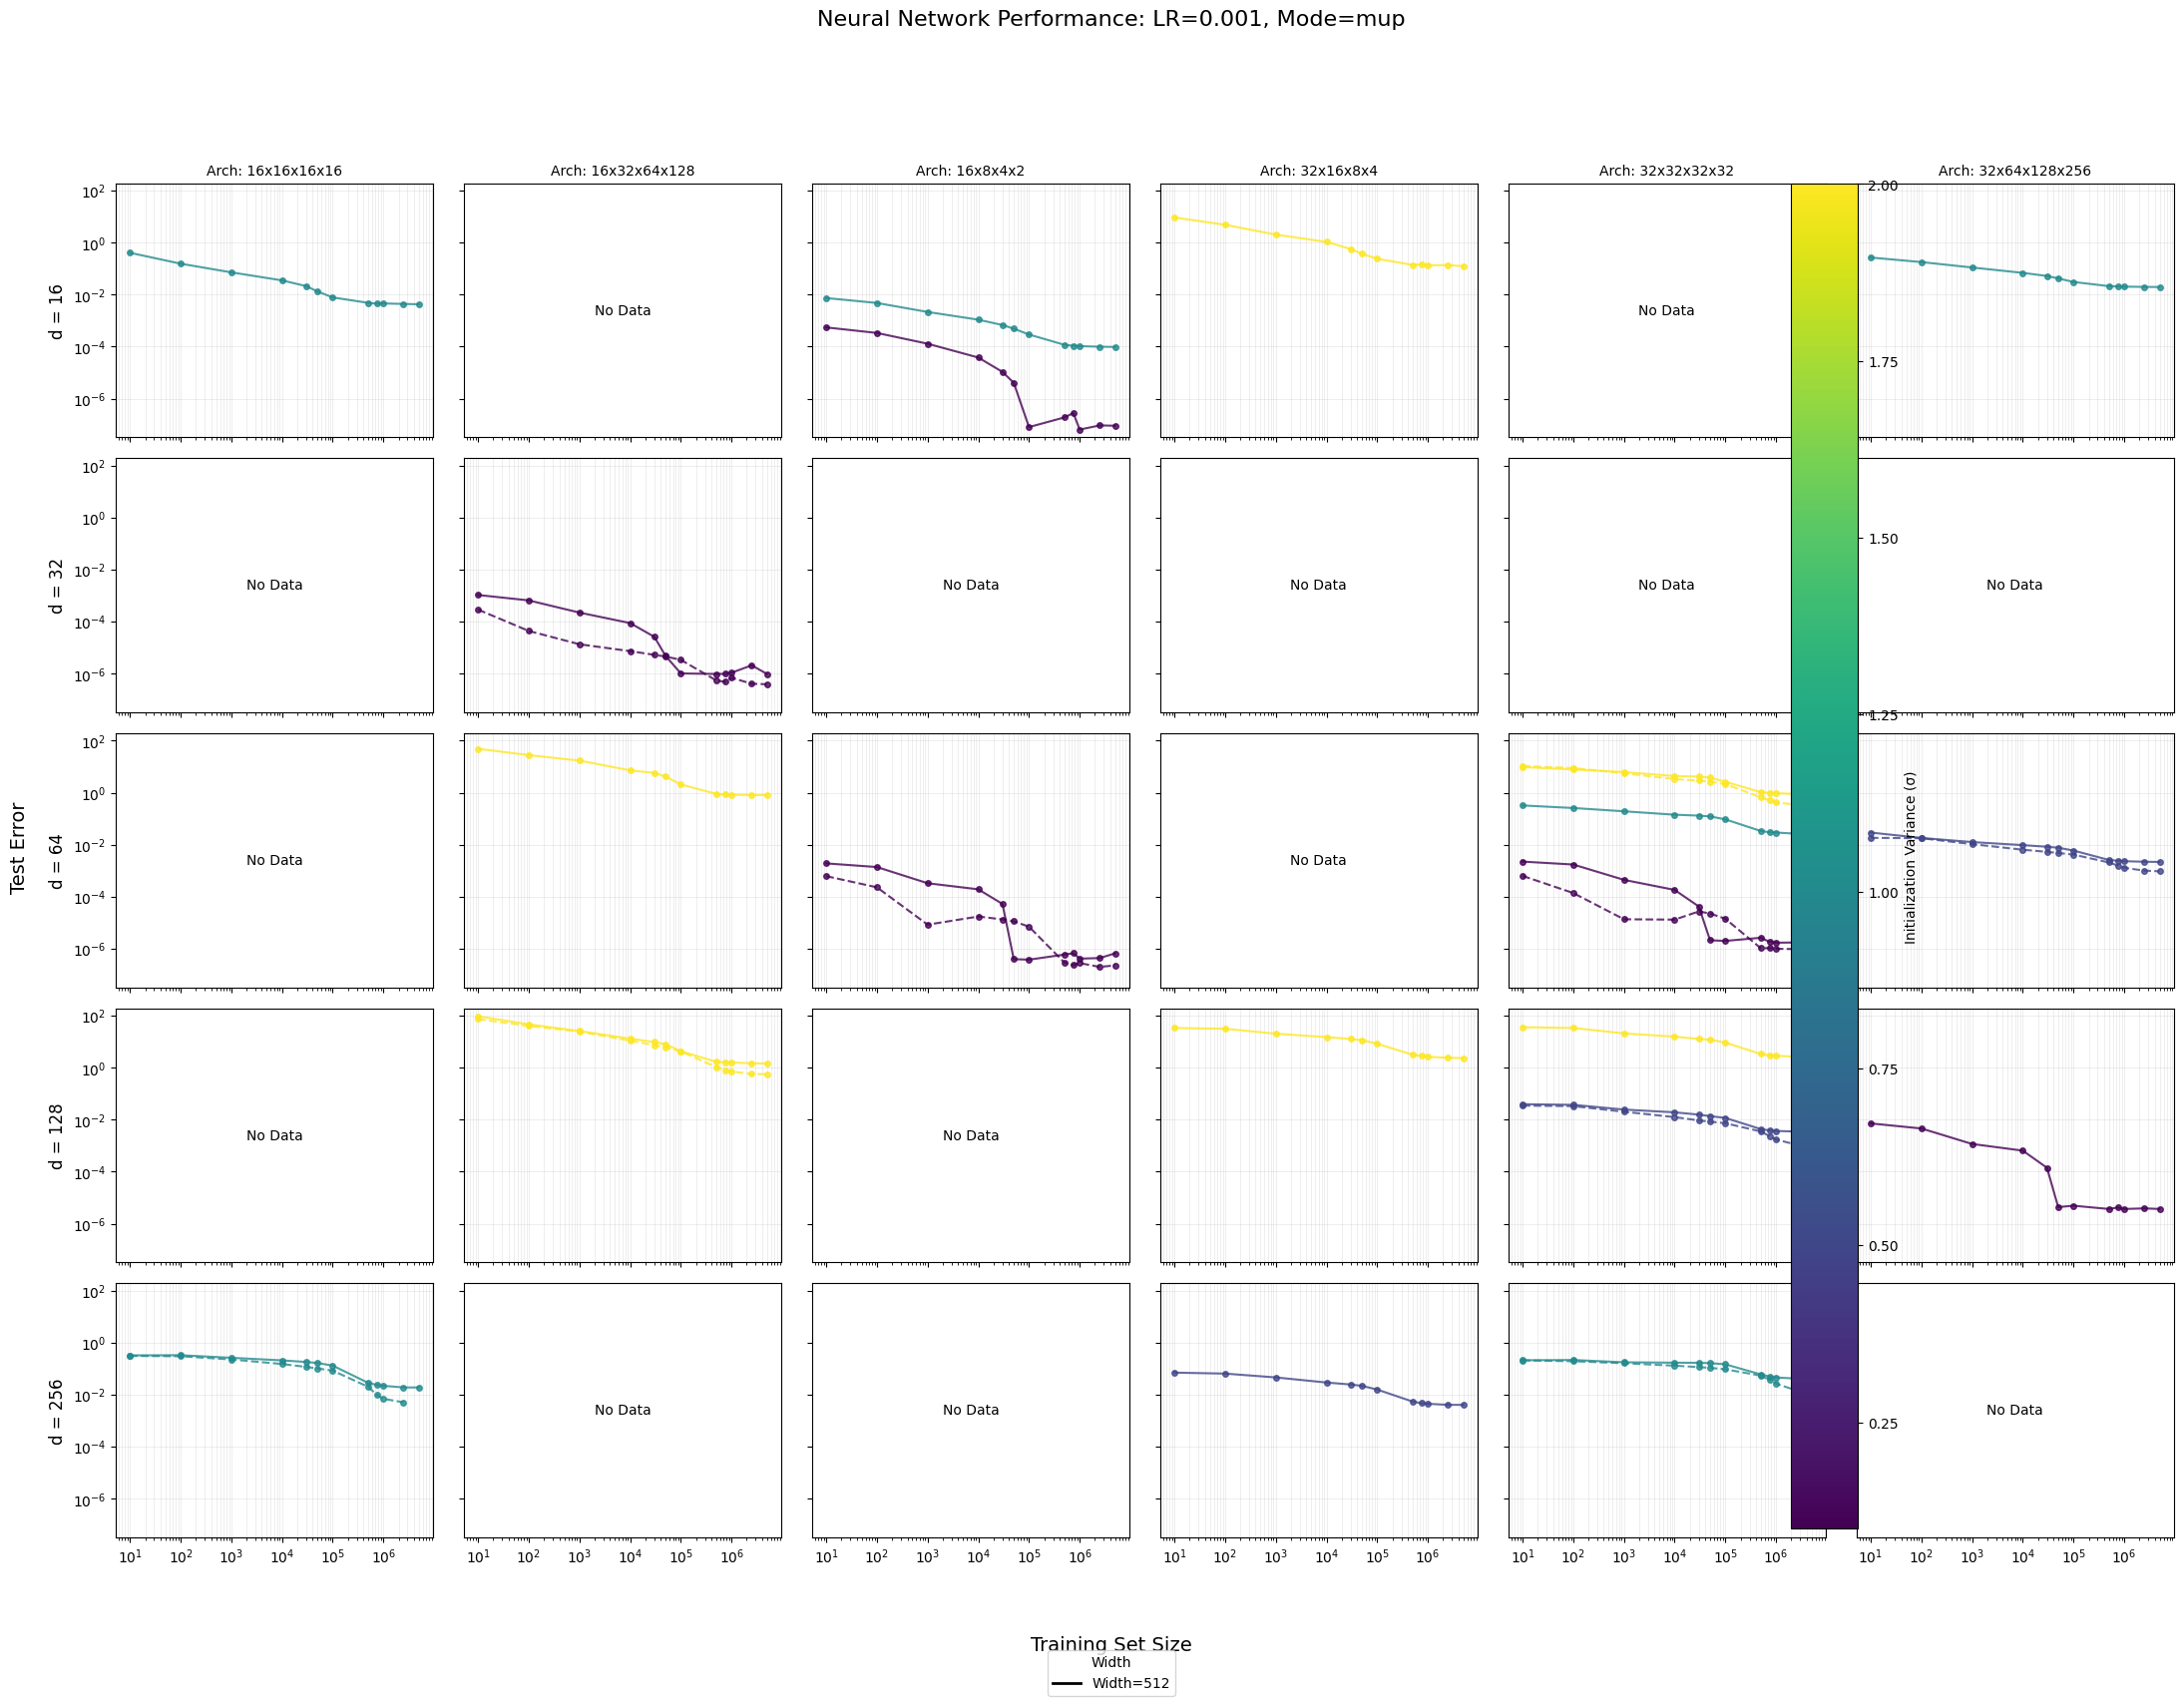

Creating grid for LR=0.001, Mode=standard


/tmp/ipykernel_1875957/2717971337.py:295: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.08, 0.95, 0.92])


Saved plot to ./result_plots_NN_grid/grid_NN_LR0p001_Modestandard.png


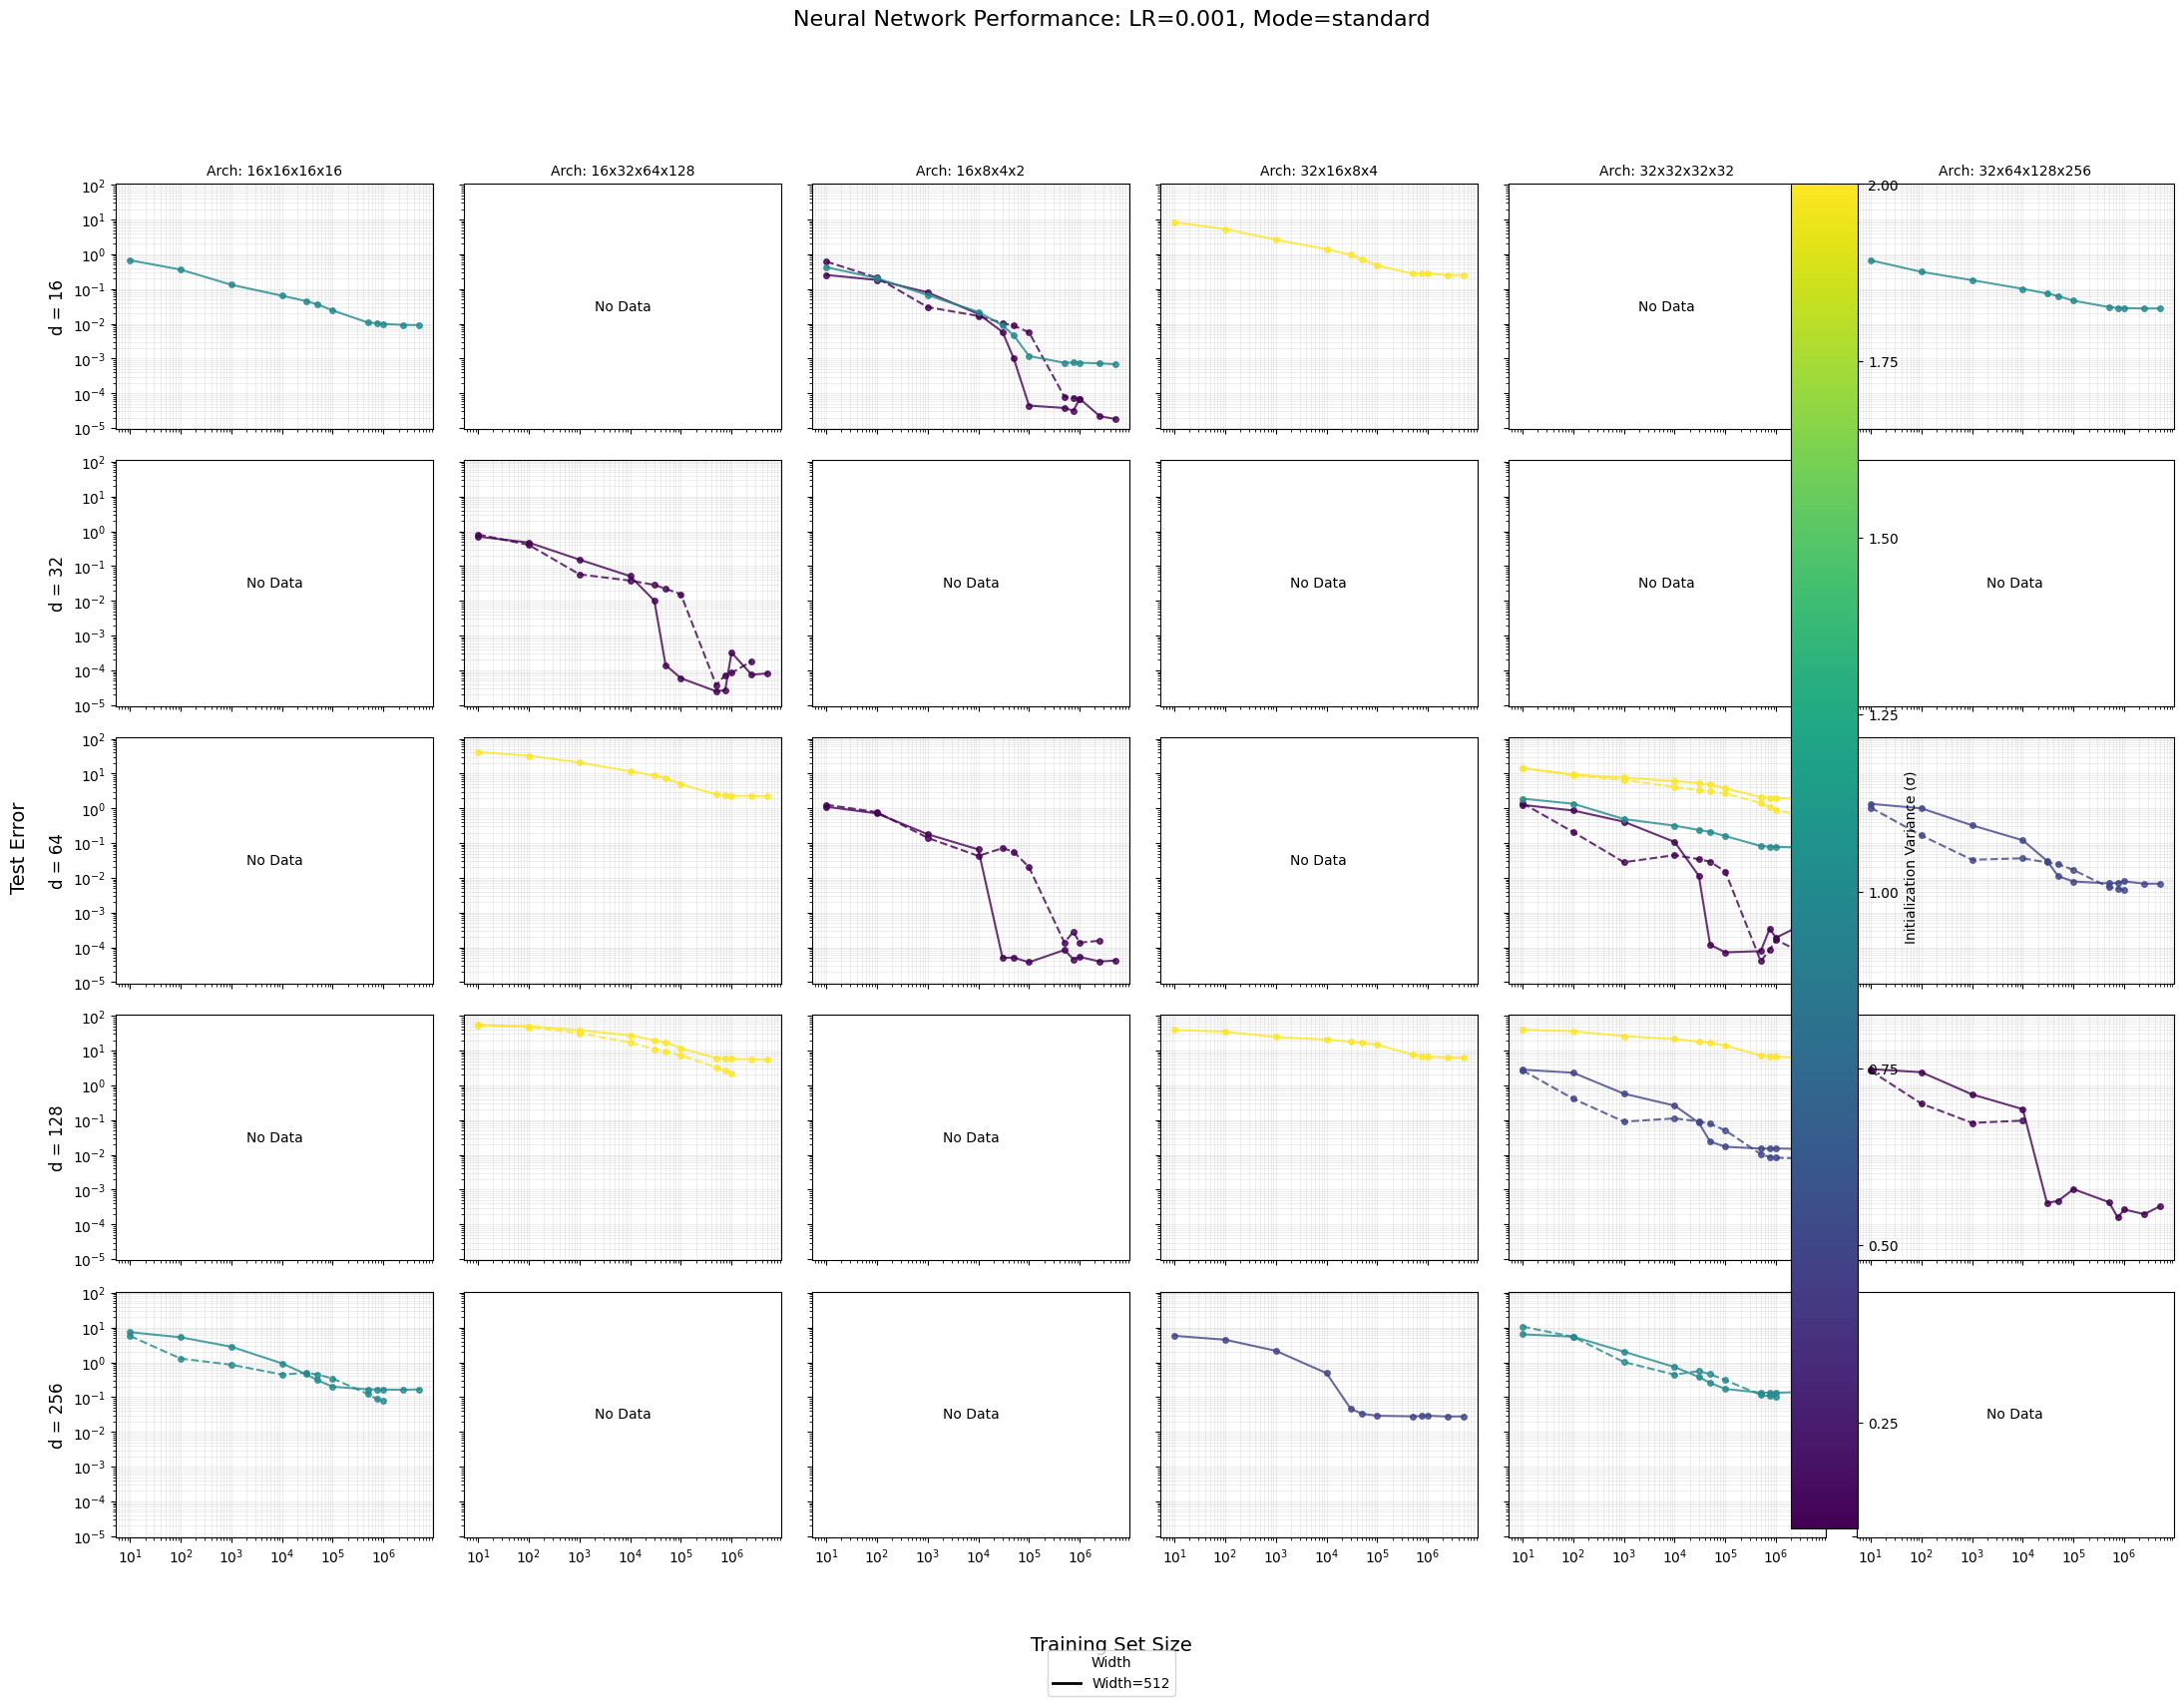

Creating grid for LR=0.01, Mode=mup


/tmp/ipykernel_1875957/2717971337.py:295: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.08, 0.95, 0.92])


Saved plot to ./result_plots_NN_grid/grid_NN_LR0p01_Modemup.png


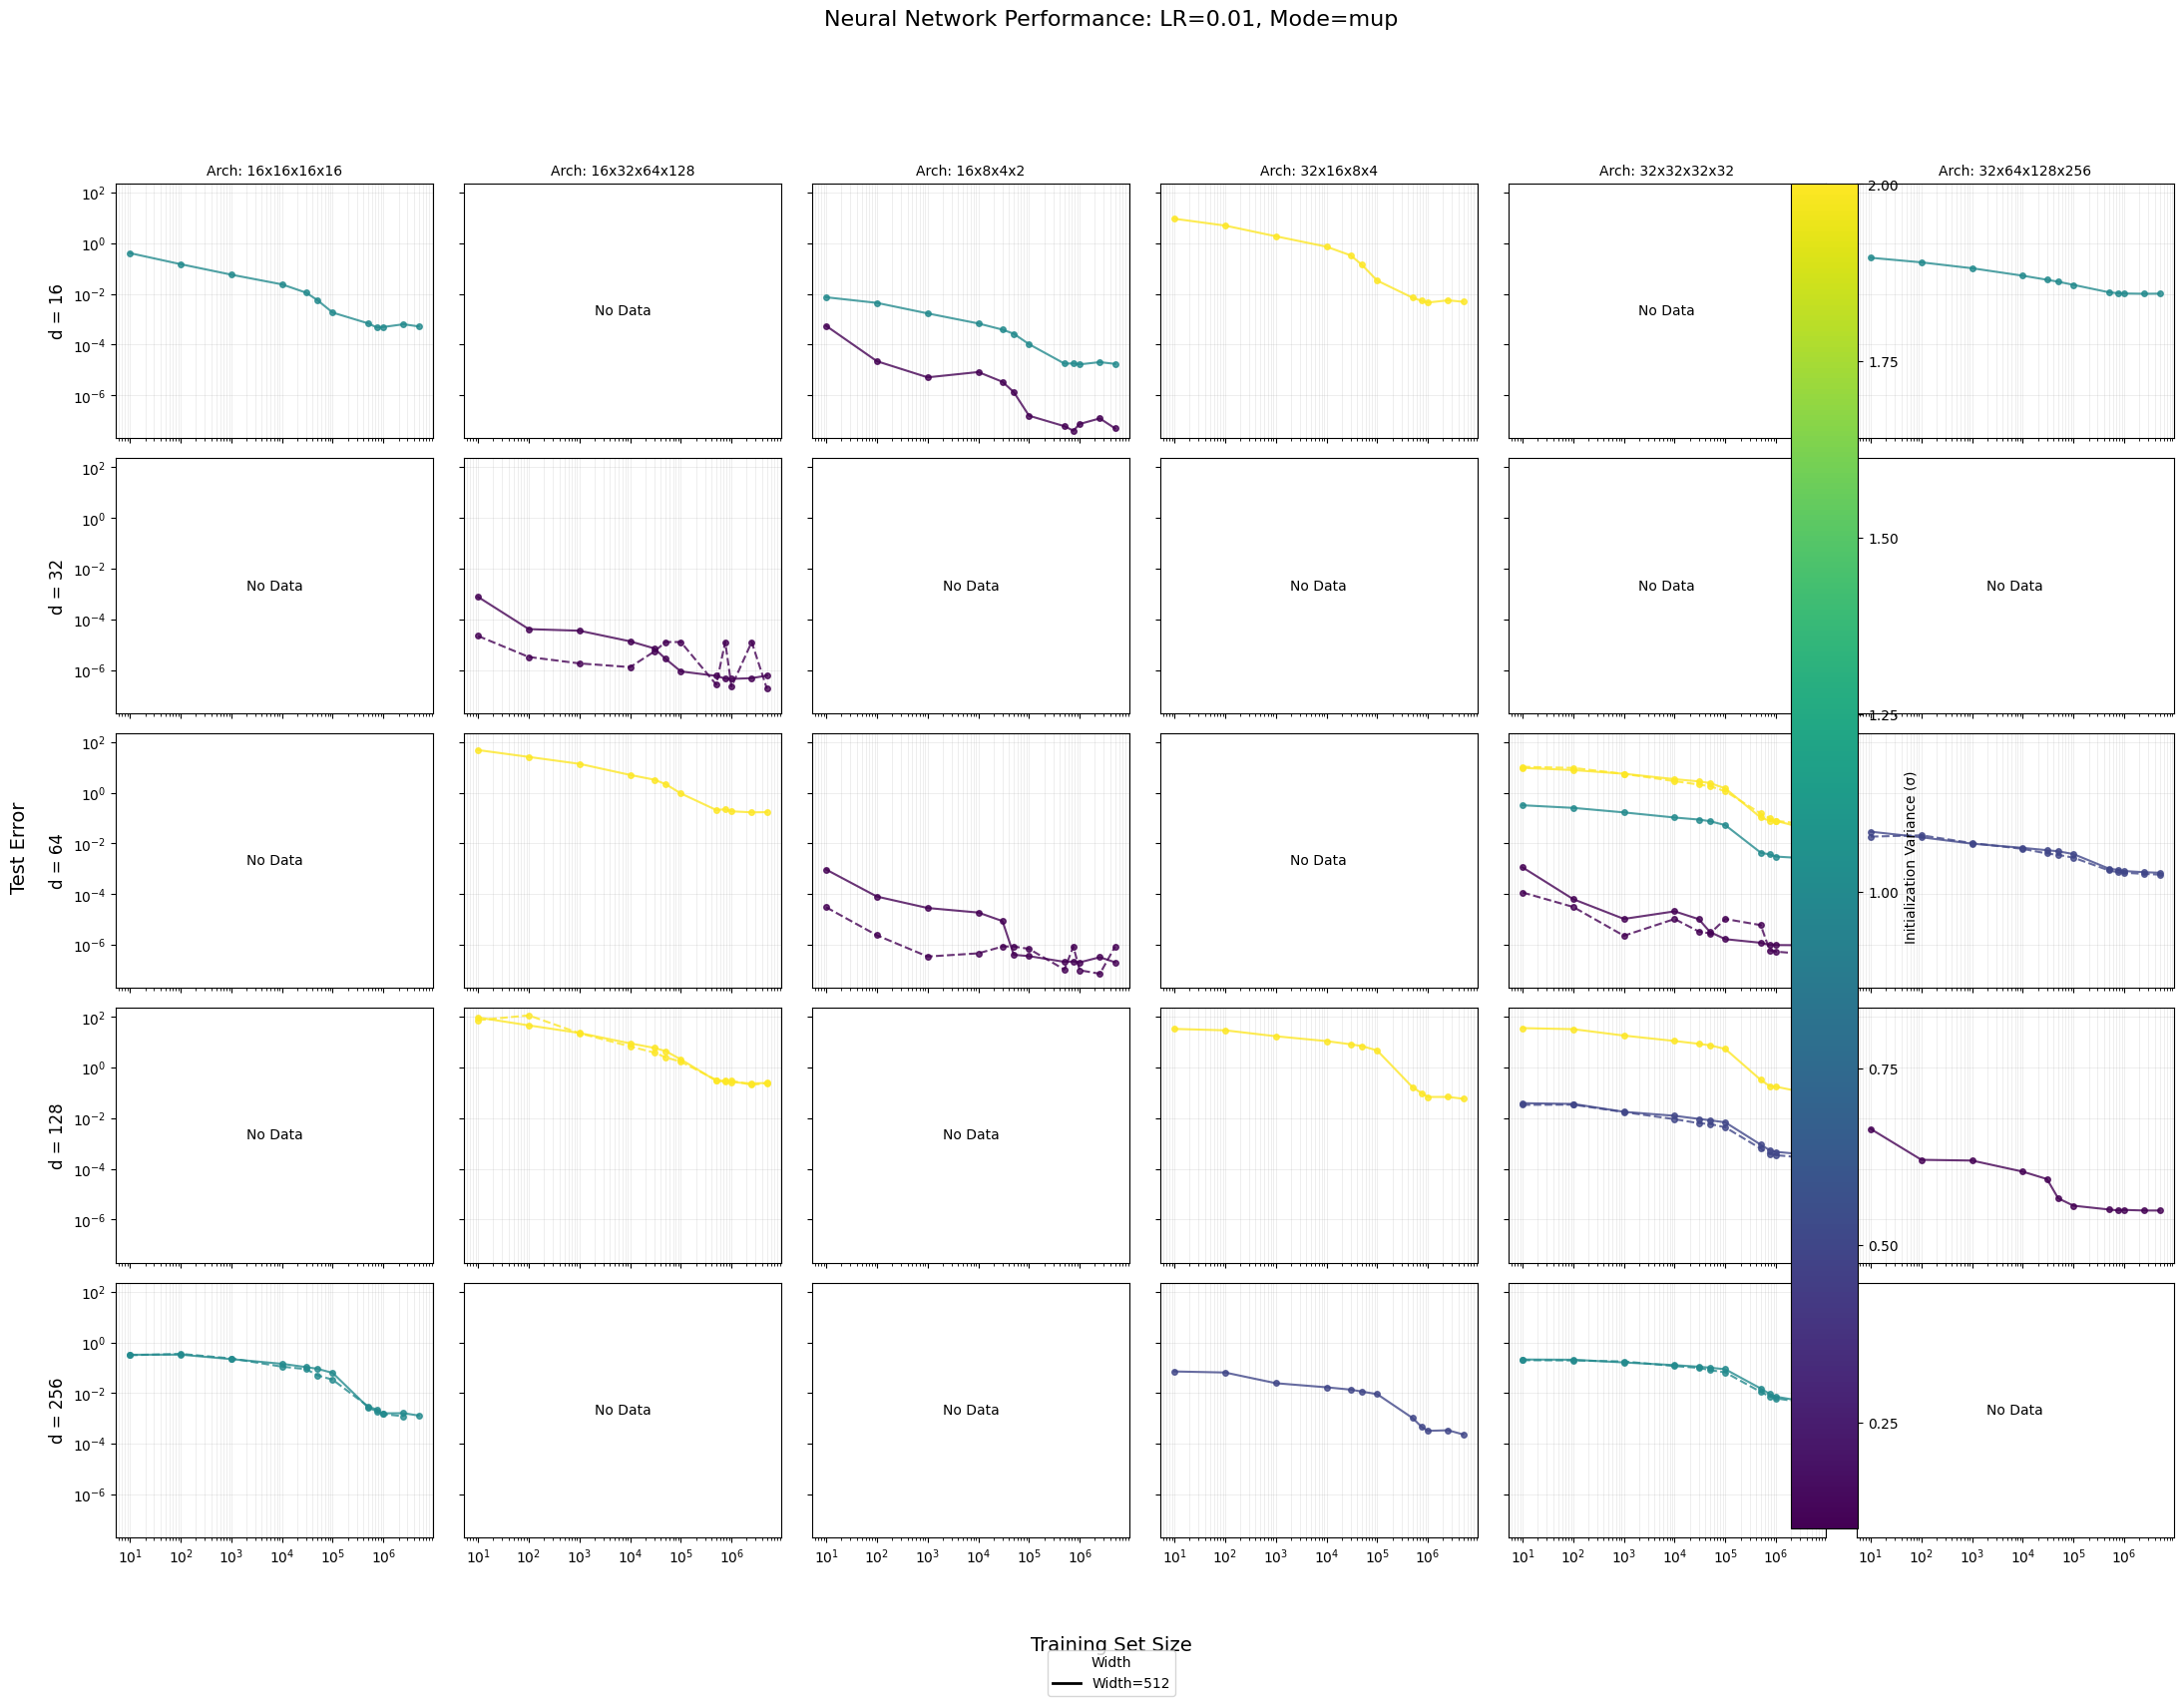

Creating grid for LR=0.01, Mode=standard


/tmp/ipykernel_1875957/2717971337.py:295: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.08, 0.95, 0.92])


Saved plot to ./result_plots_NN_grid/grid_NN_LR0p01_Modestandard.png


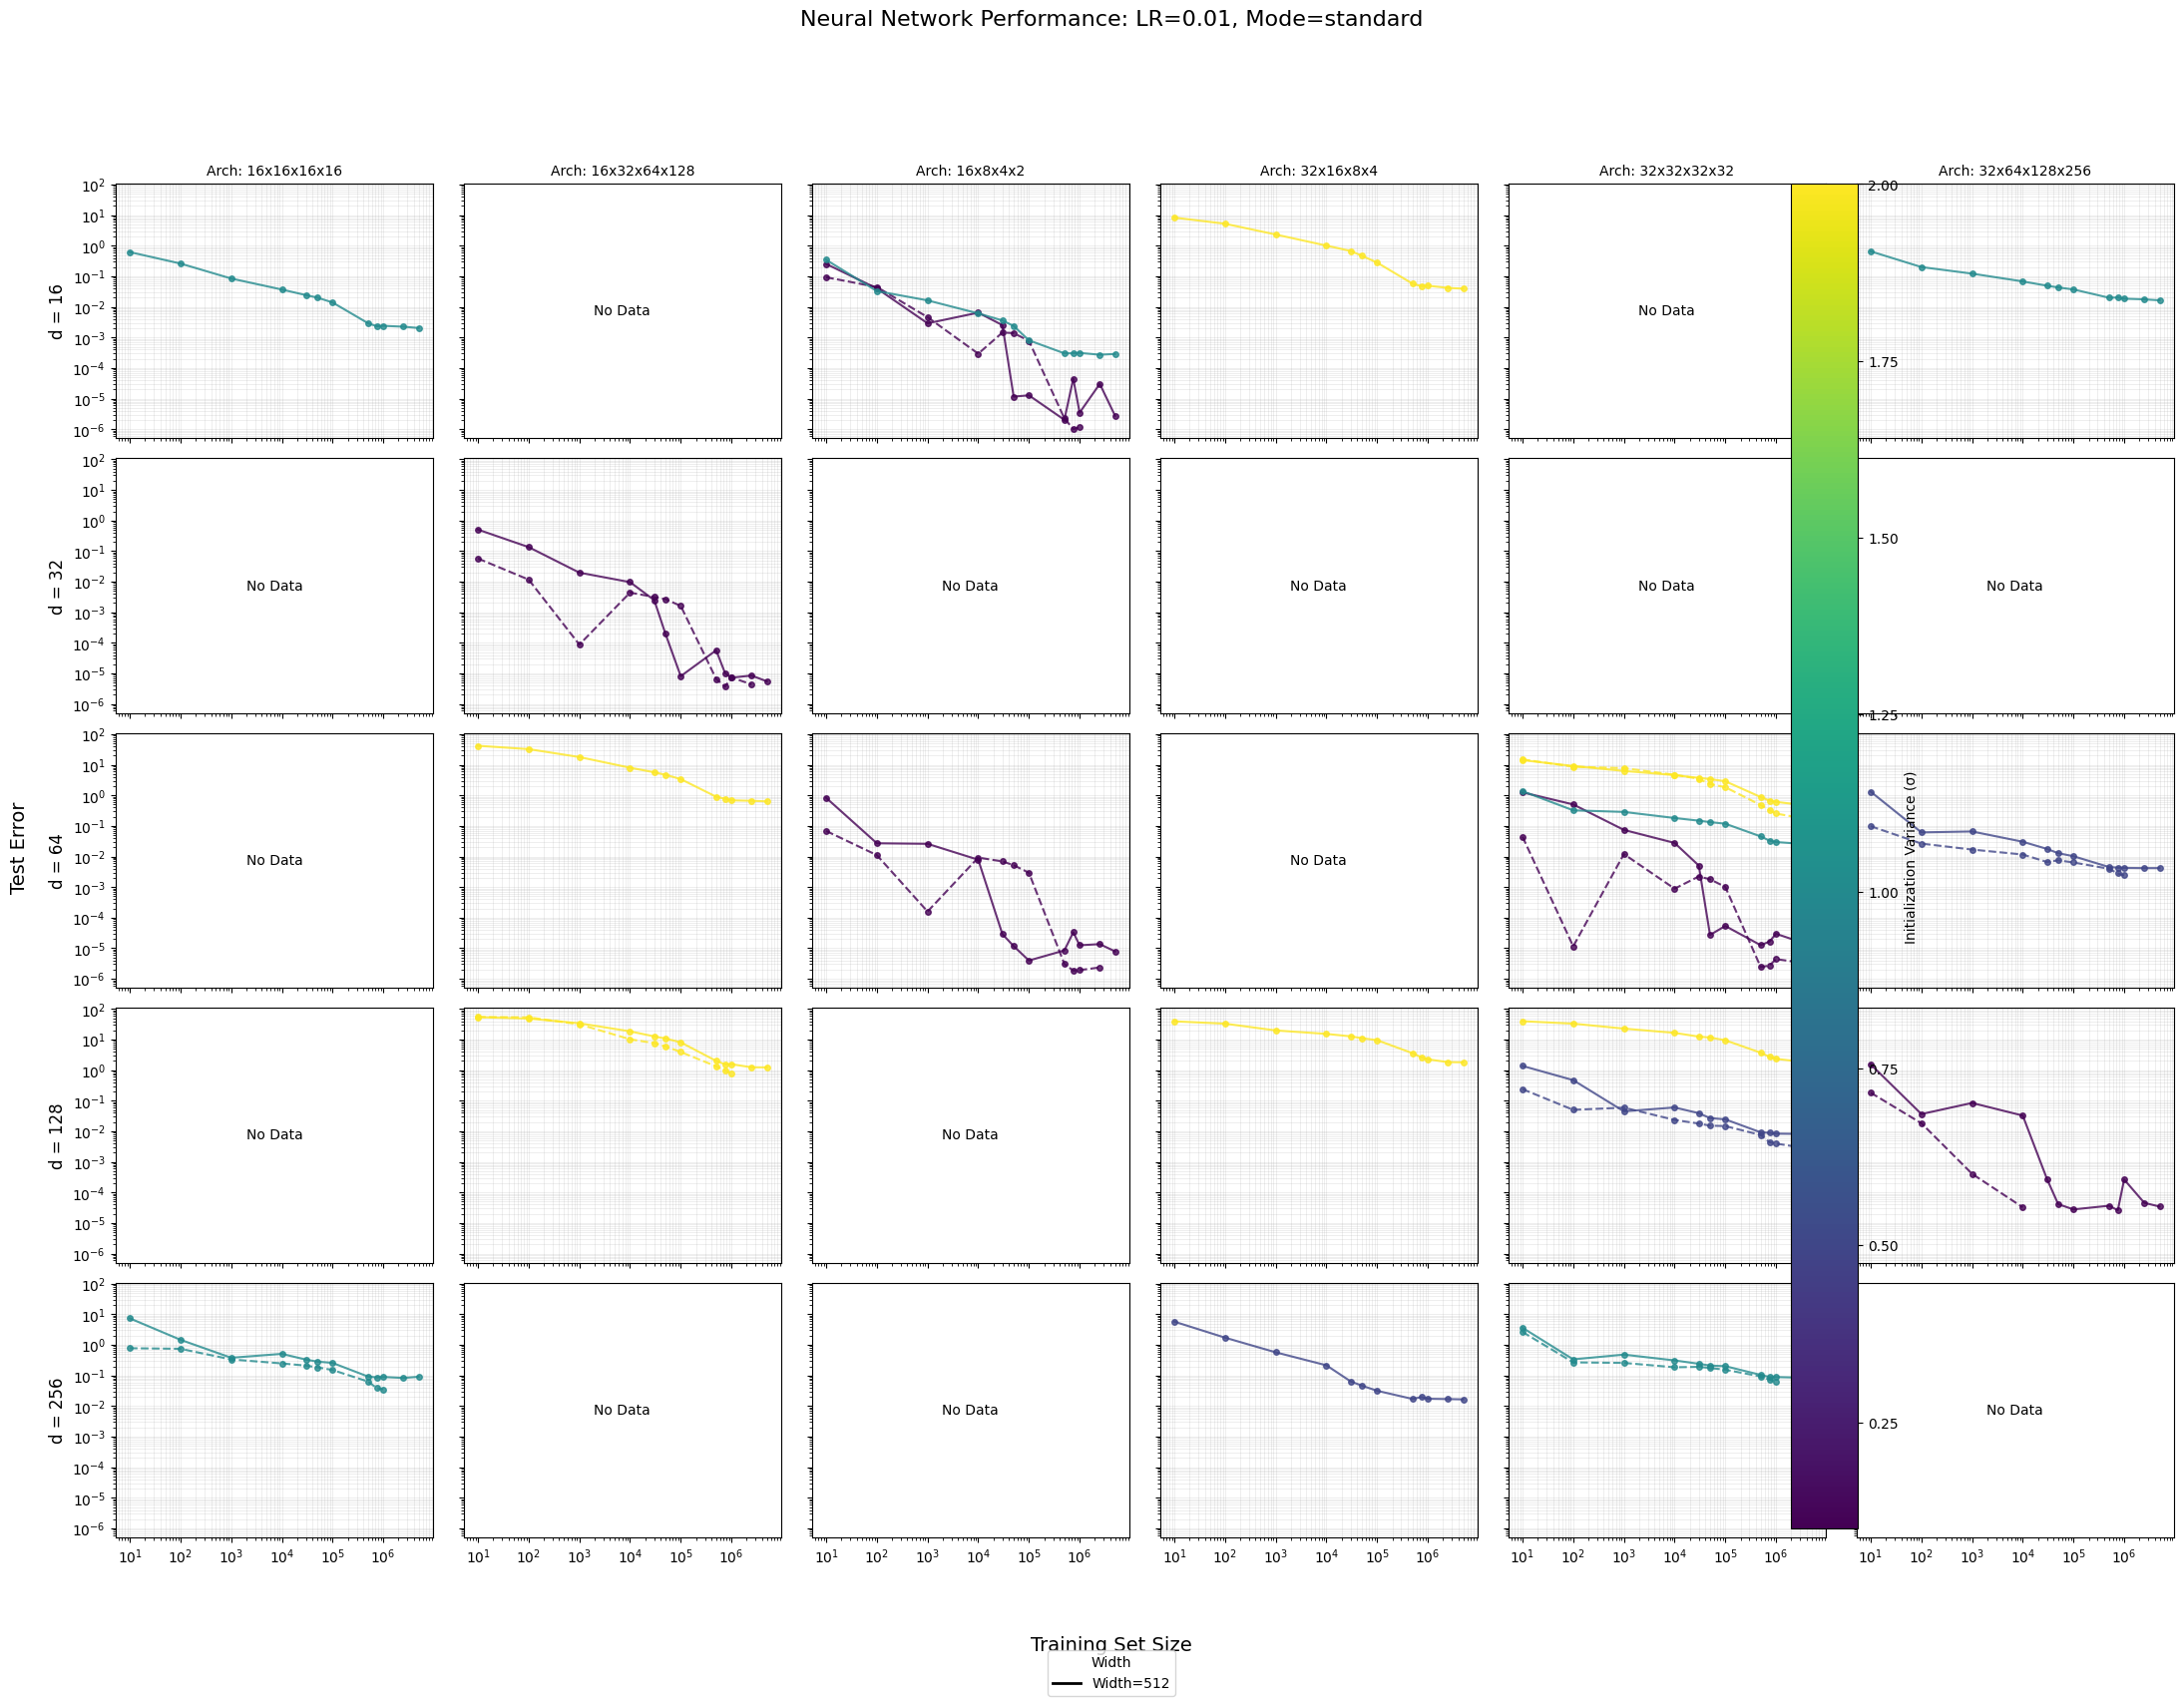

Creating grid for LR=0.05, Mode=mup


/tmp/ipykernel_1875957/2717971337.py:295: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.08, 0.95, 0.92])


Saved plot to ./result_plots_NN_grid/grid_NN_LR0p05_Modemup.png


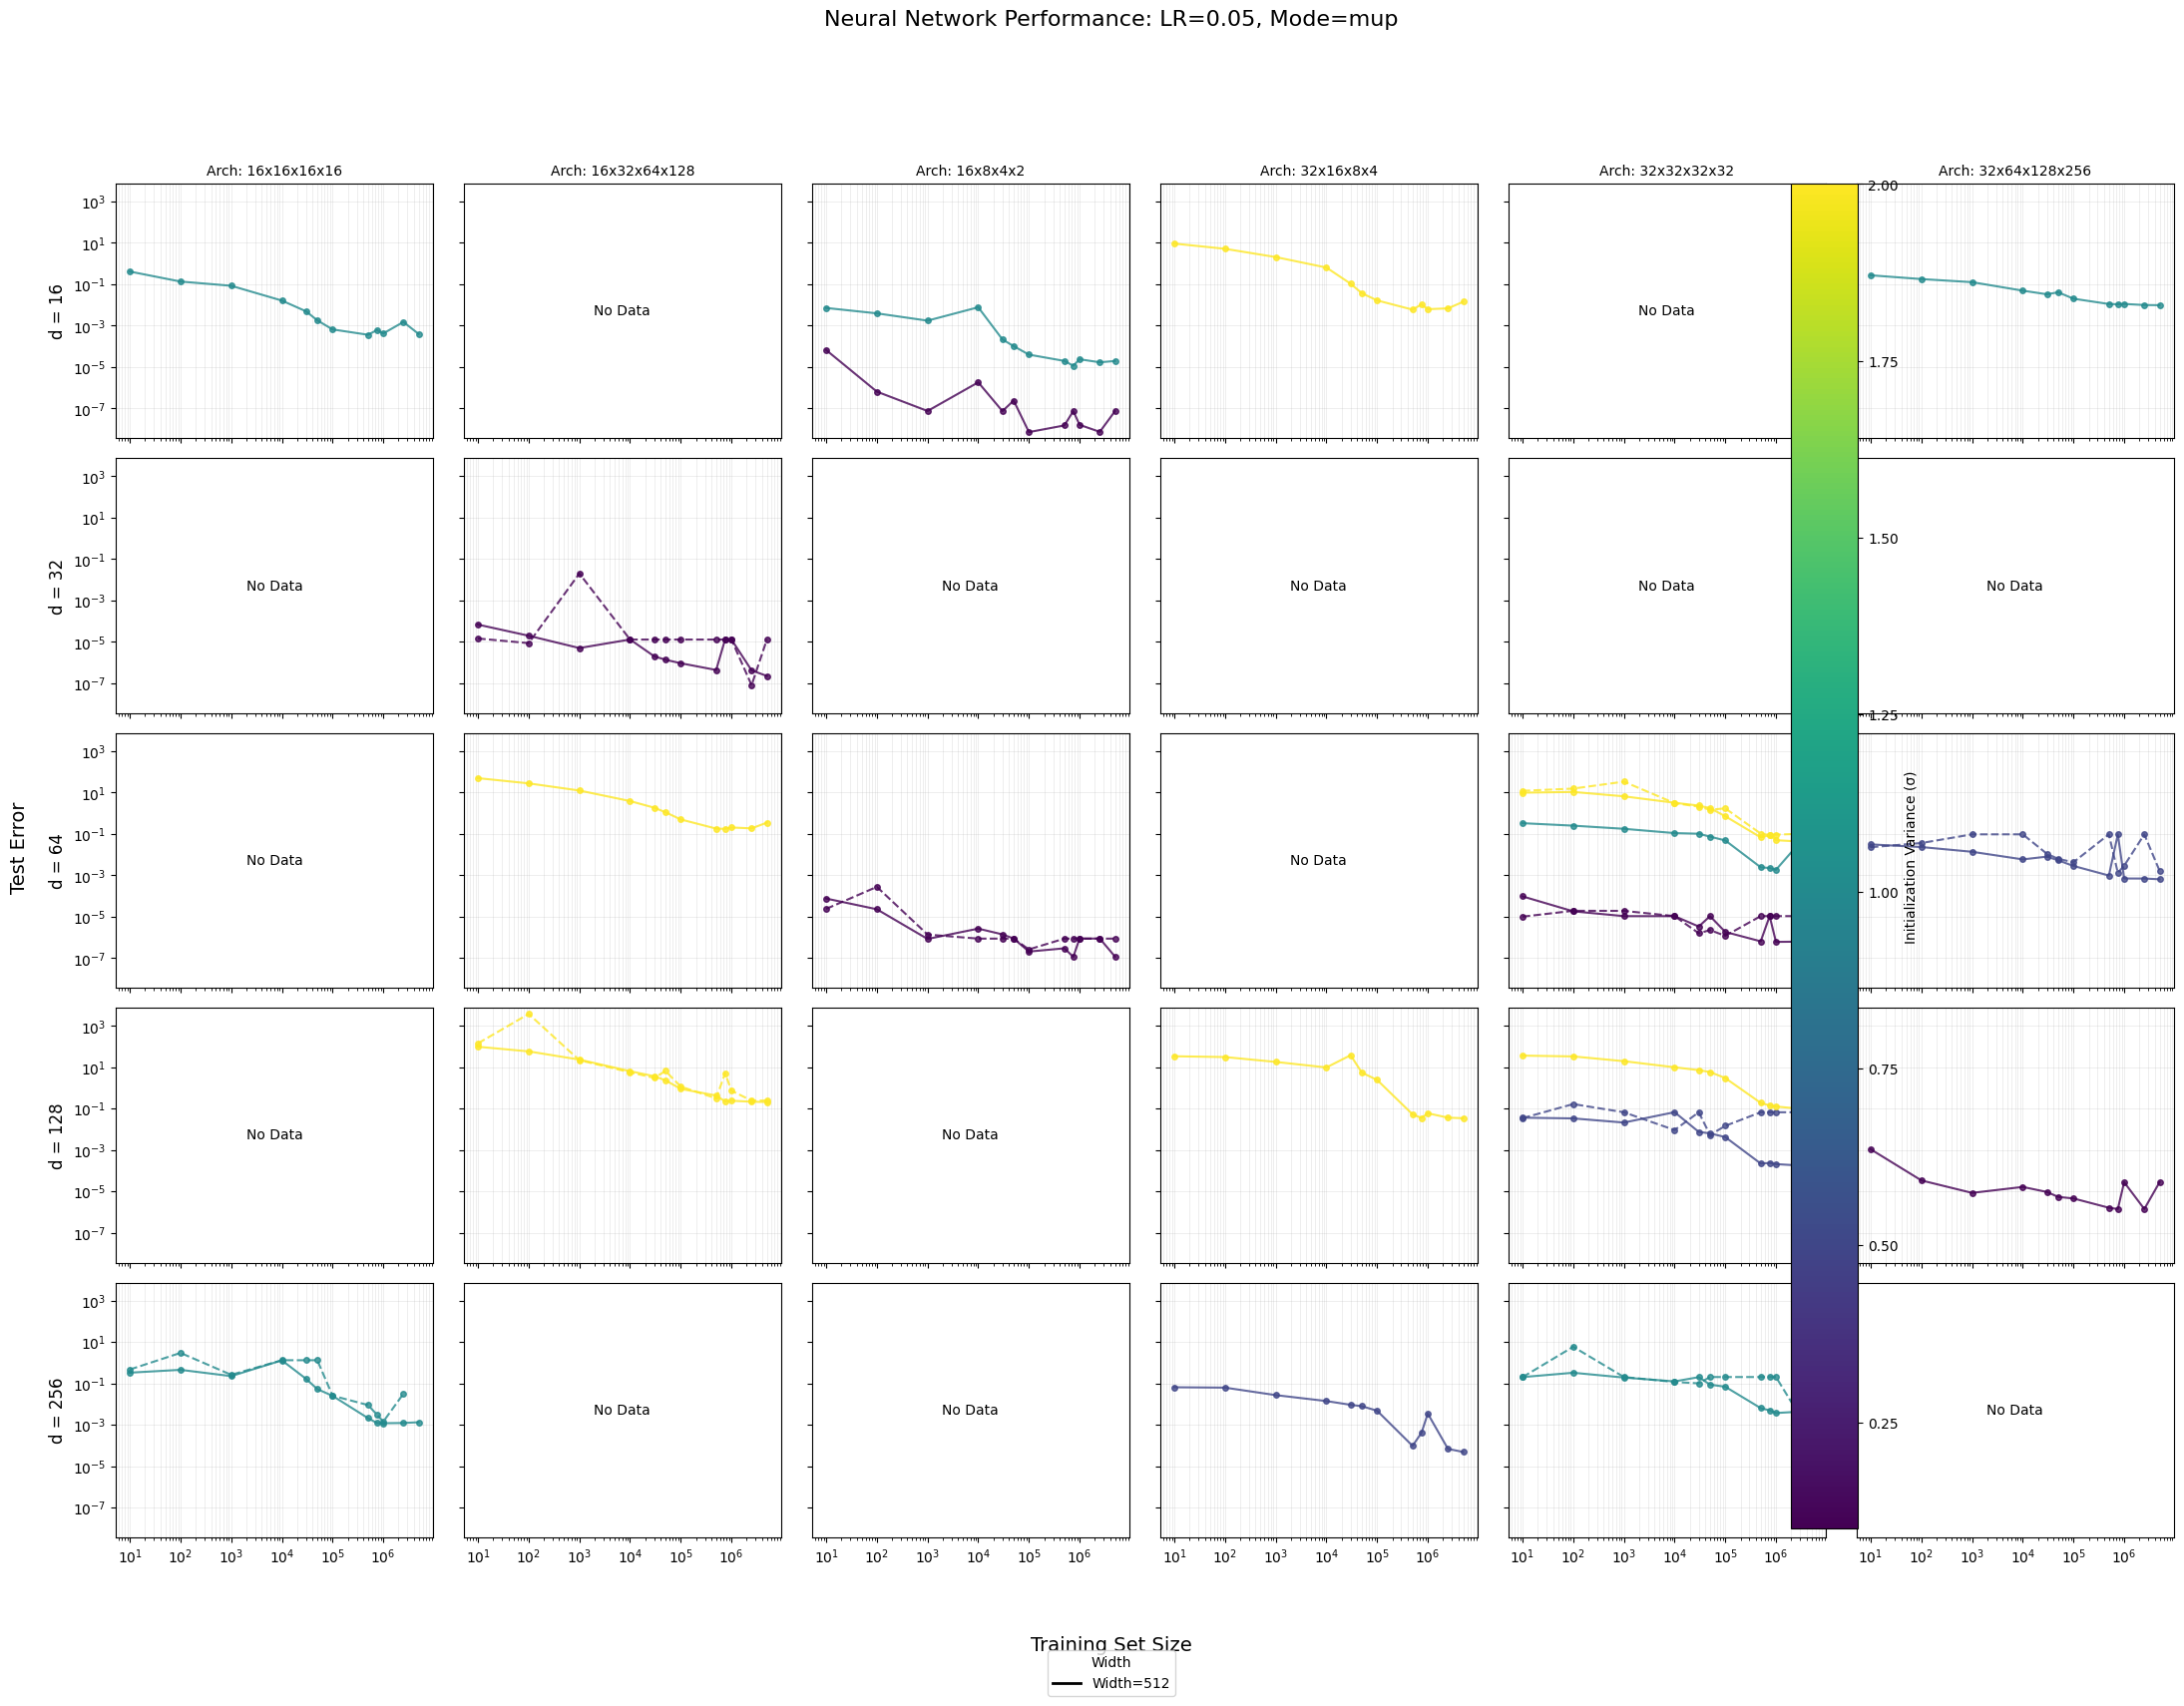

Creating grid for LR=0.05, Mode=standard


/tmp/ipykernel_1875957/2717971337.py:295: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.08, 0.95, 0.92])


Saved plot to ./result_plots_NN_grid/grid_NN_LR0p05_Modestandard.png


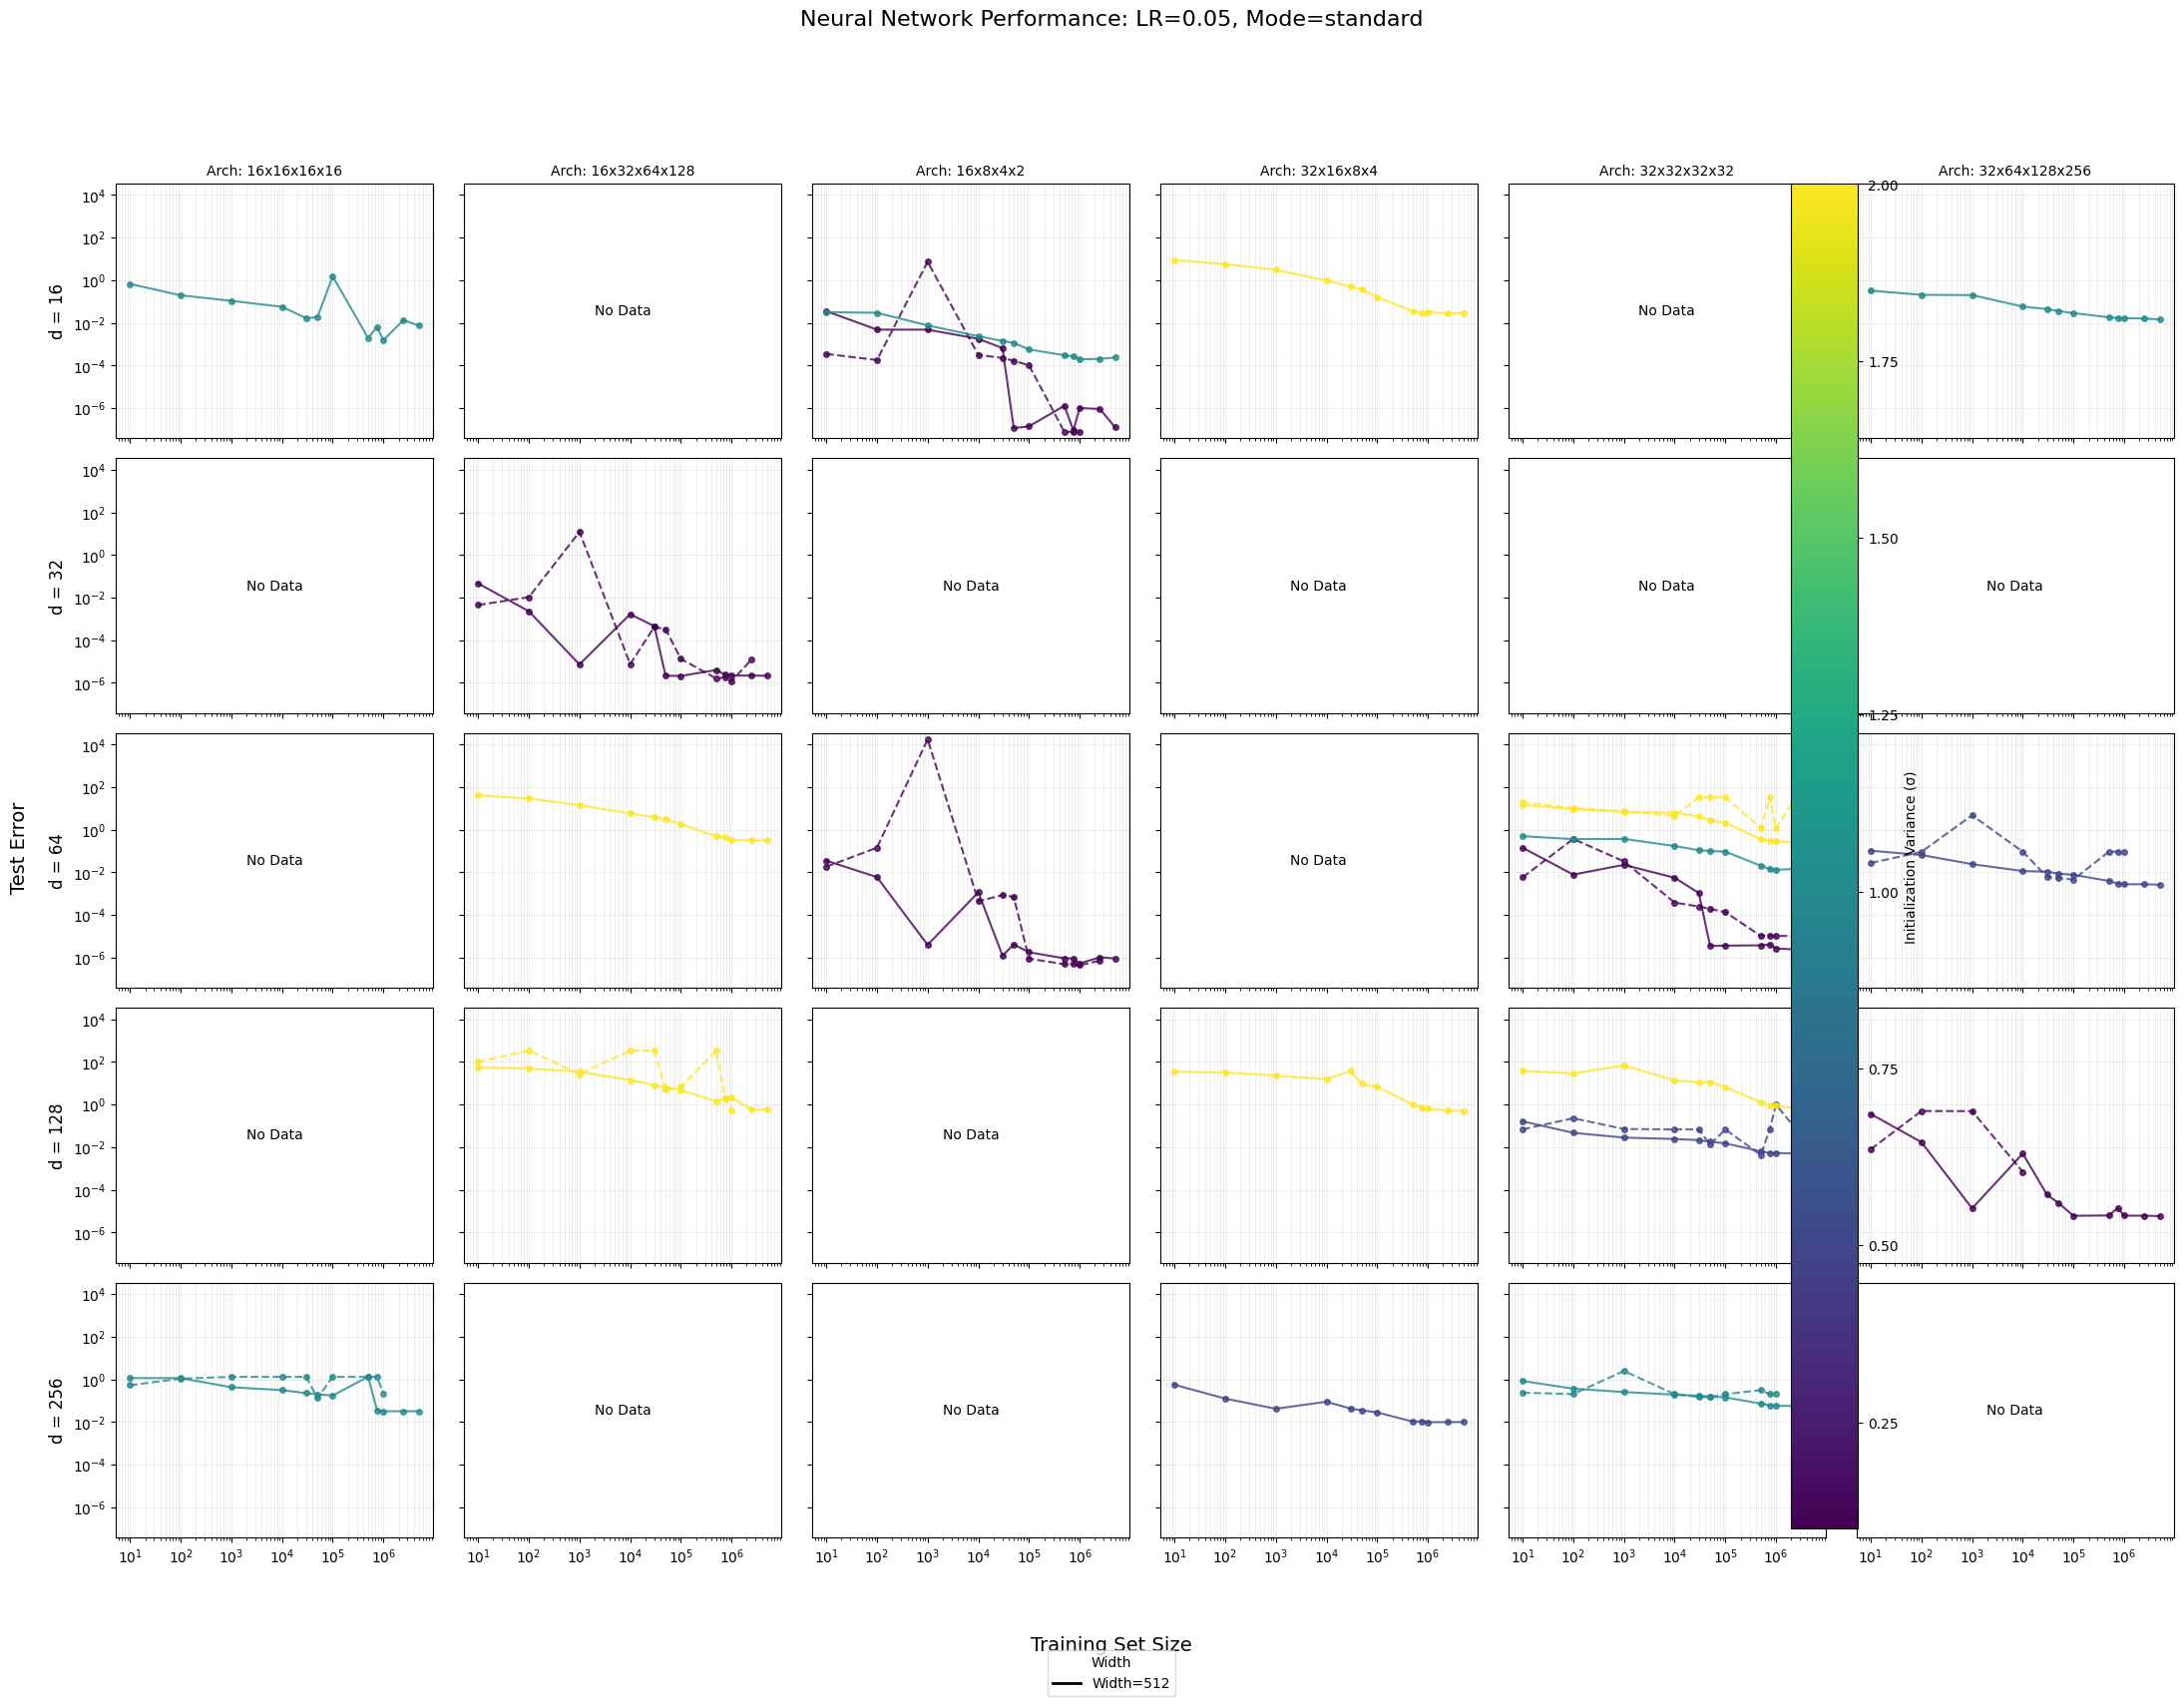

Creating grid for LR=0.5, Mode=mup


/tmp/ipykernel_1875957/2717971337.py:295: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.08, 0.95, 0.92])


Saved plot to ./result_plots_NN_grid/grid_NN_LR0p5_Modemup.png


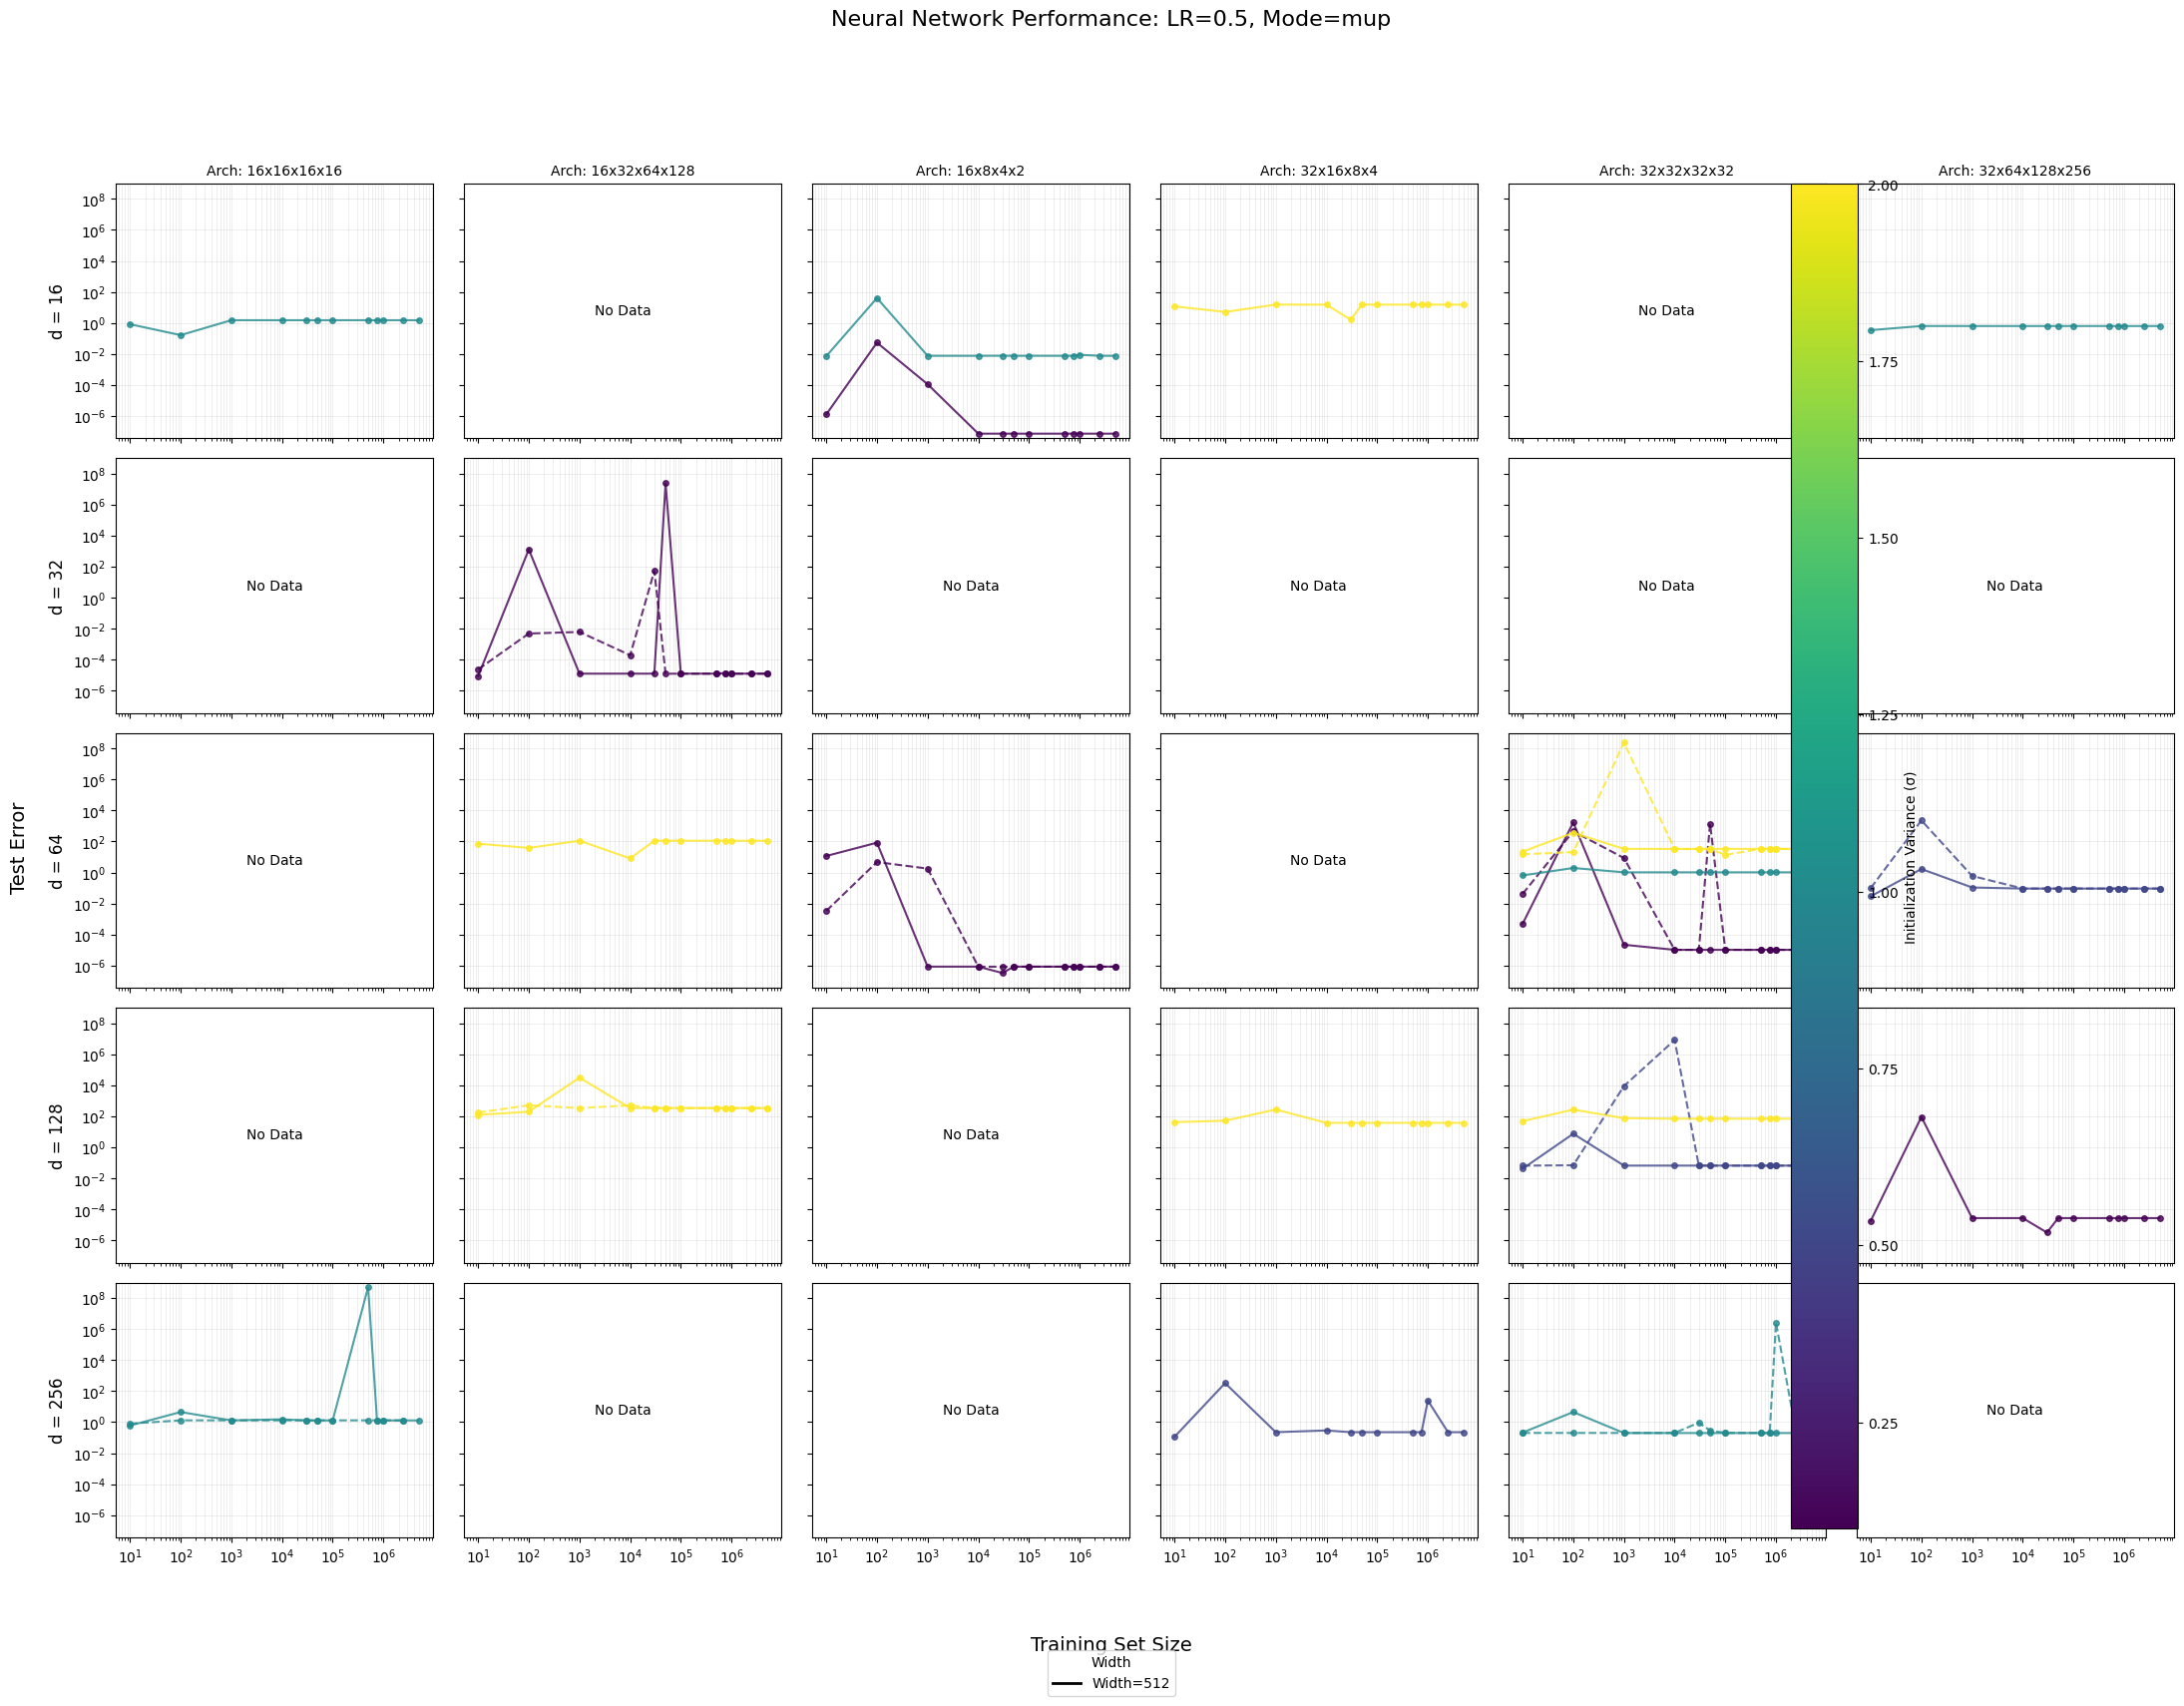

Creating grid for LR=0.5, Mode=standard


/tmp/ipykernel_1875957/2717971337.py:295: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.08, 0.95, 0.92])


Saved plot to ./result_plots_NN_grid/grid_NN_LR0p5_Modestandard.png


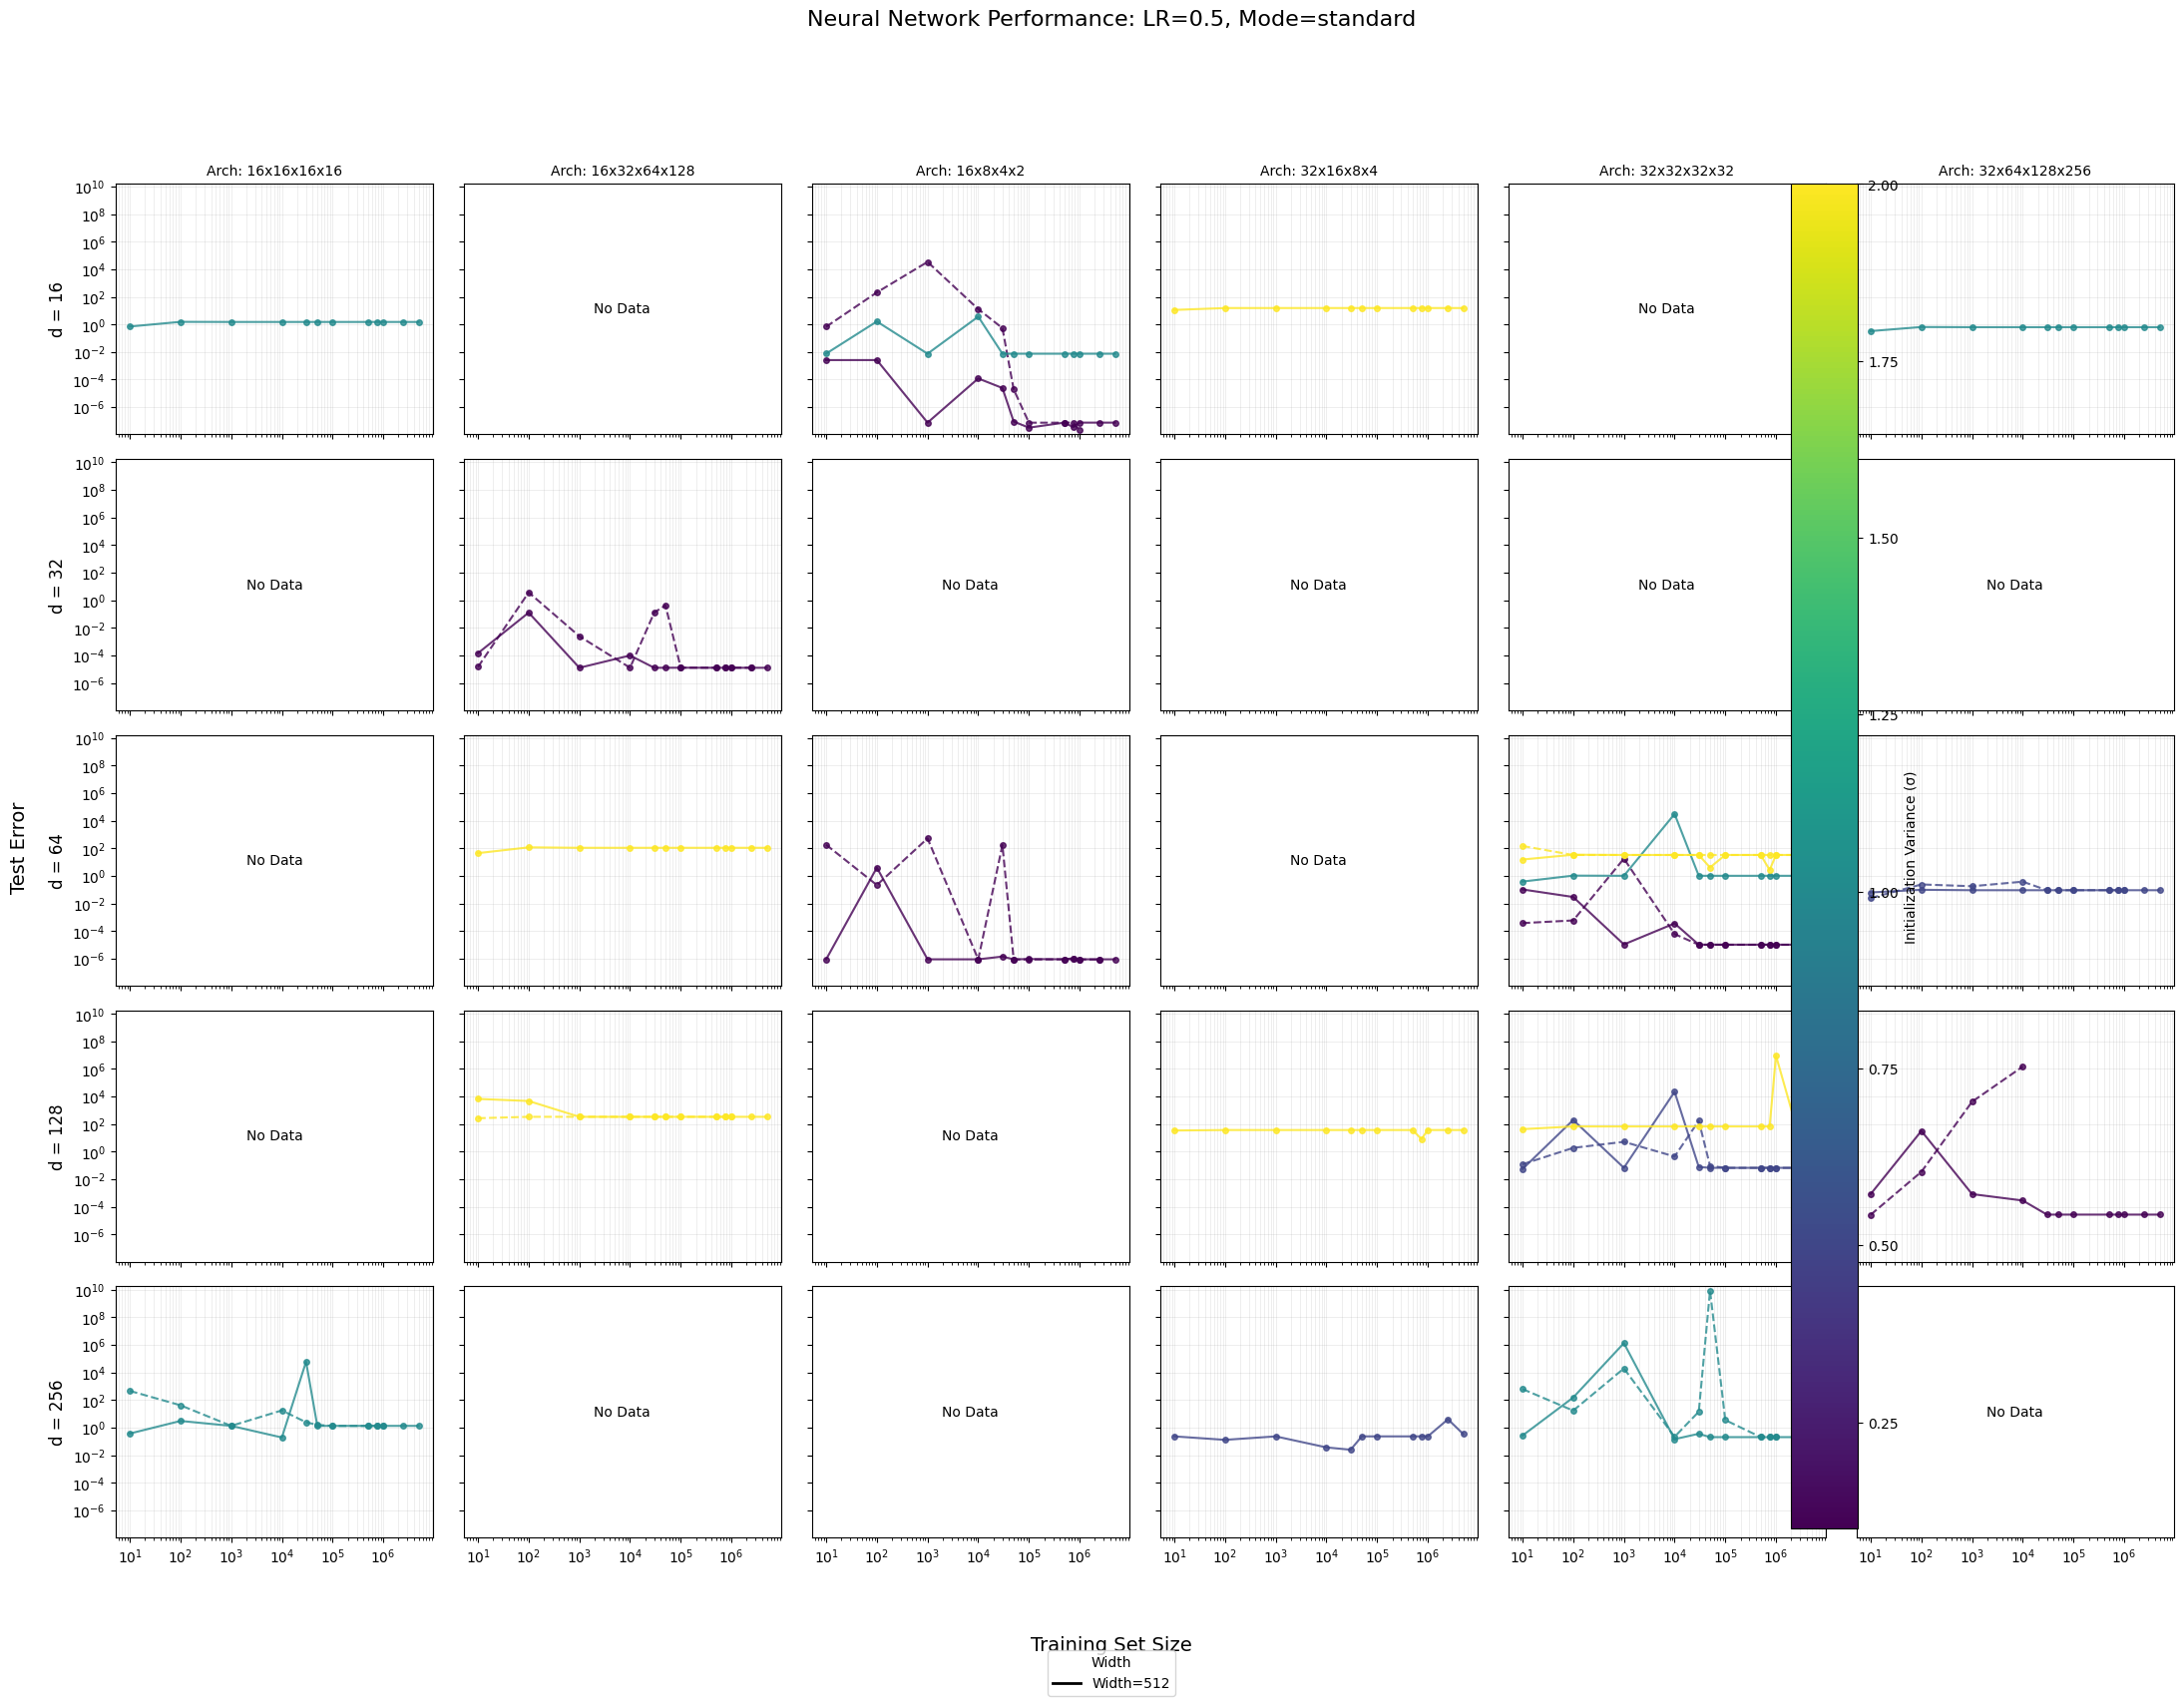

Done!


In [2]:
import os
import glob
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from matplotlib.colors import Normalize

# === Configuration ===
# Set the path to your results directory
results_dir = "/home/goring/leap/results/NN_0304/sweep_full_exp_20250403"

# Set to True to save plots to files
save_plots = True
output_dir = "./result_plots_NN_grid"

# Create output directory if needed
if save_plots:
    os.makedirs(output_dir, exist_ok=True)

def load_results(results_dir):
    """Load all result files from the specified directory."""
    result_files = []
    
    # First, try direct approach with explicit paths
    for gpu_id in range(8):
        pattern = os.path.join(results_dir, f"results_*_gpu{gpu_id}.jsonl")
        files = glob.glob(pattern)
        result_files.extend(files)
        print(f"Found {len(files)} files for GPU {gpu_id}")
    
    # If no files found, try recursive pattern
    if not result_files:
        pattern = os.path.join(results_dir, "**", "*.jsonl")
        result_files.extend(glob.glob(pattern, recursive=True))
    
    print(f"Found {len(result_files)} result files")
    if not result_files:
        print(f"No files found in {results_dir}")
        return []
    
    all_results = []
    
    for file_path in result_files:
        try:
            print(f"Processing file: {os.path.basename(file_path)}")
            valid_count = 0
            
            with open(file_path, 'r') as f:
                for line in f:
                    if line.strip():
                        try:
                            result = json.loads(line)
                            all_results.append(result)
                            valid_count += 1
                        except json.JSONDecodeError as e:
                            print(f"Error parsing JSON in {file_path}: {e}")
            
            print(f"  - Loaded {valid_count} valid results")
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    print(f"Loaded {len(all_results)} total results")
    return all_results

def process_nn_results(results):
    """Process neural network results into a DataFrame."""
    processed_data = []
    error_count = 0
    
    for result in results:
        try:
            # Check if it's a gaussian (neural network) result
            if result.get('distribution_type') != 'gaussian':
                continue
                
            # Extract basic information
            input_dim = result.get('input_dim')
            hidden_size = result.get('hidden_size')
            depth = result.get('depth')
            learning_rate = result.get('learning_rate')
            n_train = result.get('n_train')
            test_error = result.get('test_error')
            experiment_num = result.get('experiment_num', 0)
            mode = result.get('mode', 'standard')
            architecture = result.get('architecture', [])
            init_variance = result.get('init_variance', 0.1)  # Sigma value
            
            # Create architecture string
            if architecture:
                arch_str = 'x'.join(str(dim) for dim in architecture)
            else:
                arch_str = f"{hidden_size}x{depth}"
            
            # Skip if any required field is missing
            if None in [input_dim, hidden_size, depth, learning_rate, test_error, n_train, init_variance]:
                error_count += 1
                continue
            
            # Create a record
            record = {
                'input_dim': int(input_dim),
                'architecture': arch_str,
                'n_train': int(n_train),
                'test_error': float(test_error),
                'hidden_size': int(hidden_size),
                'depth': int(depth),
                'learning_rate': float(learning_rate),
                'experiment_num': int(experiment_num),
                'mode': mode,
                'init_variance': float(init_variance)  # Add sigma (initialization variance)
            }
            
            processed_data.append(record)
        except Exception as e:
            error_count += 1
            print(f"Error processing result: {e}")
            continue
    
    print(f"Processed {len(processed_data)} valid NN results, skipped {error_count} invalid results")
    
    # Convert to DataFrame
    df = pd.DataFrame(processed_data)
    
    # Print unique values for debugging
    if not df.empty:
        print(f"Unique dimensions: {sorted(df['input_dim'].unique())}")
        print(f"Unique architectures: {sorted(df['architecture'].unique())}")
        print(f"Unique learning rates: {sorted(df['learning_rate'].unique())}")
        print(f"Unique sigma values: {sorted(df['init_variance'].unique())}")
        print(f"Unique modes: {sorted(df['mode'].unique())}")
    
    return df

def create_grid_plots(df):
    """
    Create separate grid plots for each LR and mode combination.
    Within each grid, use different colors for sigma values and line styles for widths.
    """
    # Get unique values
    learning_rates = sorted(df['learning_rate'].unique())
    modes = sorted(df['mode'].unique())
    sigma_values = sorted(df['init_variance'].unique())
    
    # Get unique dimensions and architectures for the grid
    dimensions = sorted(df['input_dim'].unique())
    architectures = sorted(df['architecture'].unique())
    hidden_sizes = sorted(df['hidden_size'].unique())
    
    # Width line style mapping
    width_styles = {size: style for size, style in zip(
        hidden_sizes, 
        ['-', '--', '-.', ':'] * (1 + len(hidden_sizes)//4)
    )}
    
    # Color map for sigma values
    colormap = cm.viridis
    norm = Normalize(vmin=min(sigma_values), vmax=max(sigma_values))
    
    # Create separate plots for each LR and mode combination
    for lr in learning_rates:
        for mode in modes:
            print(f"Creating grid for LR={lr}, Mode={mode}")
            
            # Filter data for this LR and mode
            subset = df[(df['learning_rate'] == lr) & (df['mode'] == mode)]
            
            if subset.empty:
                print(f"  - No data for this combination")
                continue
            
            # Create a grid of plots
            fig, axes = plt.subplots(
                nrows=len(dimensions),
                ncols=len(architectures),
                figsize=(len(architectures)*4, len(dimensions)*3.5),
                sharex=True,
                sharey=True,
                squeeze=False
            )
            
            # Set the figure title
            fig.suptitle(f'Neural Network Performance: LR={lr}, Mode={mode}', fontsize=16)
            
            # Add common x and y labels
            fig.text(0.5, 0.04, 'Training Set Size', ha='center', fontsize=14)
            fig.text(0.04, 0.5, 'Test Error', va='center', rotation='vertical', fontsize=14)
            
            # Calculate global min and max for y-axis
            min_error = subset['test_error'].min() * 0.5
            max_error = subset['test_error'].max() * 2.0
            
            # Create legend elements for widths
            width_legend_elements = []
            
            # Fill in each cell of the grid
            for i, dim in enumerate(dimensions):
                for j, arch in enumerate(architectures):
                    ax = axes[i, j]
                    
                    # Set cell title
                    if i == 0:  # Top row gets architecture
                        ax.set_title(f'Arch: {arch}', fontsize=10)
                    
                    if j == 0:  # First column gets dimension
                        ax.set_ylabel(f'd = {dim}', fontsize=12)
                    
                    # Filter data for this cell
                    cell_data = subset[(subset['input_dim'] == dim) & (subset['architecture'] == arch)]
                    
                    if cell_data.empty:
                        ax.text(0.5, 0.5, 'No Data', 
                               ha='center', va='center', transform=ax.transAxes)
                        continue
                    
                    # Log scales
                    ax.set_xscale('log')
                    ax.set_yscale('log')
                    
                    # Plot lines for each combination of sigma and width
                    for sigma in sigma_values:
                        for h_size in hidden_sizes:
                            # Get data for this combination
                            point_data = cell_data[
                                (cell_data['init_variance'] == sigma) & 
                                (cell_data['hidden_size'] == h_size)
                            ]
                            
                            if point_data.empty:
                                continue
                            
                            # Handle duplicates by averaging
                            point_data = point_data.groupby('n_train')['test_error'].mean().reset_index()
                            
                            # Sort by n_train for proper line plotting
                            point_data = point_data.sort_values('n_train')
                            
                            if len(point_data) <= 1:
                                continue  # Need at least two points to draw a line
                            
                            # Get color based on sigma value
                            color = colormap(norm(sigma))
                            
                            # Get line style based on width
                            linestyle = width_styles.get(h_size, '-')
                            
                            # Plot data points and line
                            line, = ax.plot(
                                point_data['n_train'],
                                point_data['test_error'],
                                color=color,
                                linestyle=linestyle,
                                marker='o',
                                markersize=4,
                                alpha=0.8,
                                label=f'σ={sigma}, W={h_size}'
                            )
                            
                            # Add width to legend elements once per combination
                            if i == 0 and j == 0:
                                # Only add unique elements
                                if f'Width={h_size}' not in [le.get_label() for le in width_legend_elements]:
                                    width_legend_elements.append(
                                        Line2D([0], [0], color='black', linestyle=linestyle, lw=2, 
                                               label=f'Width={h_size}')
                                    )
                    
                    # Set the y-axis limits
                    if min_error > 0 and max_error > 0:
                        ax.set_ylim(min_error, max_error)
                    
                    # Add grid
                    ax.grid(True, which='both', linestyle='-', linewidth=0.5, alpha=0.3)
            
            # Add colorbar for sigma values
            sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
            sm.set_array([])
            cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), label='Initialization Variance (σ)')
            
            # Add width legend
            if width_legend_elements:
                fig.legend(
                    handles=width_legend_elements,
                    loc='lower center',
                    ncol=min(4, len(width_legend_elements)),
                    bbox_to_anchor=(0.5, 0.01),
                    fontsize=10,
                    title="Width"
                )
            
            # Adjust layout
            plt.tight_layout(rect=[0.05, 0.08, 0.95, 0.92])
            
            # Save figure if requested
            if save_plots:
                lr_str = str(lr).replace('.', 'p')
                filename = f'grid_NN_LR{lr_str}_Mode{mode}.png'
                save_path = os.path.join(output_dir, filename)
                plt.savefig(save_path, dpi=300, bbox_inches='tight')
                print(f"Saved plot to {save_path}")
            
            plt.show()

def main():
    print("Starting neural network grid plot creation...")
    
    # Load results
    results = load_results(results_dir)
    
    if not results:
        print("No results were loaded. Please check paths and file formats.")
        return
    
    # Process results
    df = process_nn_results(results)
    
    if len(df) == 0:
        print("No valid neural network data entries after processing.")
        return
    
    # Print summary statistics
    print(f"\nProcessed {len(df)} data points with:")
    print(f"  - {df['learning_rate'].nunique()} learning rates: {sorted(df['learning_rate'].unique())}")
    print(f"  - {df['hidden_size'].nunique()} hidden sizes: {sorted(df['hidden_size'].unique())}")
    print(f"  - {df['depth'].nunique()} depths: {sorted(df['depth'].unique())}")
    print(f"  - {df['input_dim'].nunique()} dimensions: {sorted(df['input_dim'].unique())}")
    print(f"  - {df['architecture'].nunique()} architectures: {sorted(df['architecture'].unique())}")
    print(f"  - {df['mode'].nunique()} modes: {sorted(df['mode'].unique())}")
    print(f"  - {df['init_variance'].nunique()} sigma values: {sorted(df['init_variance'].unique())}")
    
    # Create the grid plots
    create_grid_plots(df)
    
    print("Done!")

if __name__ == "__main__":
    main()

Starting neural network grid plot creation with k-factor on y-axis...
Found 1 files for GPU 0
Found 1 files for GPU 1
Found 0 files for GPU 2
Found 0 files for GPU 3
Found 0 files for GPU 4
Found 0 files for GPU 5
Found 0 files for GPU 6
Found 0 files for GPU 7
Found 2 result files
Processing file: results_20250404_031342_gpu0.jsonl
  - Loaded 54 valid results
Processing file: results_20250404_031342_gpu1.jsonl
  - Loaded 48 valid results
Loaded 102 total results
Processed 102 valid NN results, skipped 0 invalid results
Unique dimensions: [np.int64(8)]
Unique architectures: ['5x3x2x1']
Unique learning rates: [np.float64(0.0001), np.float64(0.001), np.float64(0.01)]
Unique sigma values: [np.float64(1.0)]
Unique modes: ['mup', 'standard']
Unique k-factors: [np.float64(0.6666666666666666)]
Unique dataset depths: [np.int64(4)]

Processed 102 data points with:
  - 3 learning rates: [np.float64(0.0001), np.float64(0.001), np.float64(0.01)]
  - 2 hidden sizes: [np.int64(512), np.int64(2048)]


/tmp/ipykernel_1875957/489952870.py:335: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.08, 0.95, 0.92])


Saved plot to ./result_plots_NN_k_grid/grid_NN_k_factor_LR0p0001_Modemup.png


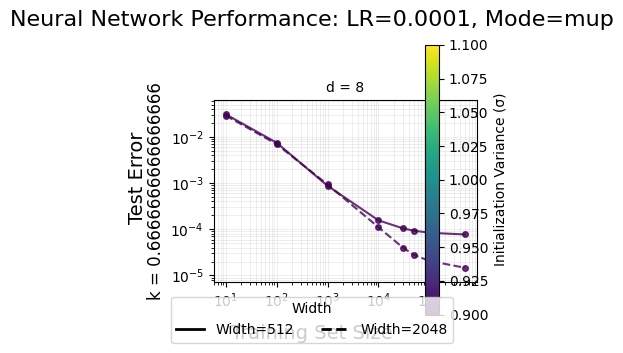

Creating grid for LR=0.0001, Mode=standard


/tmp/ipykernel_1875957/489952870.py:335: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.08, 0.95, 0.92])


Saved plot to ./result_plots_NN_k_grid/grid_NN_k_factor_LR0p0001_Modestandard.png


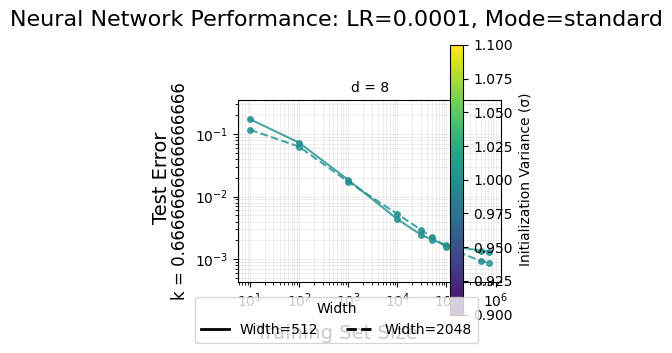

Creating grid for LR=0.001, Mode=mup


/tmp/ipykernel_1875957/489952870.py:335: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.08, 0.95, 0.92])


Saved plot to ./result_plots_NN_k_grid/grid_NN_k_factor_LR0p001_Modemup.png


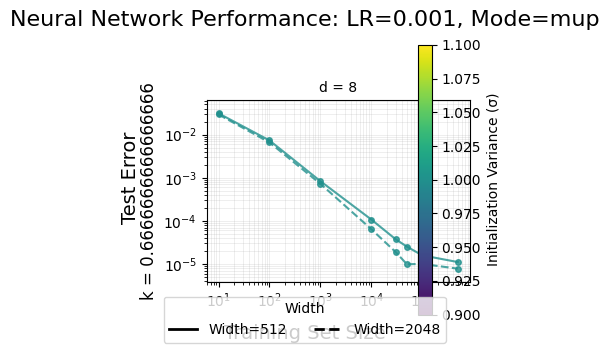

Creating grid for LR=0.001, Mode=standard


/tmp/ipykernel_1875957/489952870.py:335: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.08, 0.95, 0.92])


Saved plot to ./result_plots_NN_k_grid/grid_NN_k_factor_LR0p001_Modestandard.png


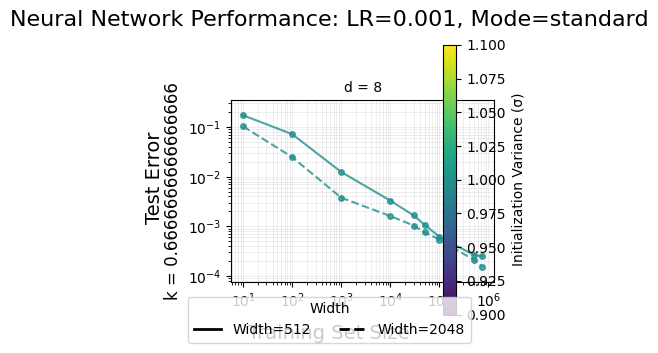

Creating grid for LR=0.01, Mode=mup


/tmp/ipykernel_1875957/489952870.py:335: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.08, 0.95, 0.92])


Saved plot to ./result_plots_NN_k_grid/grid_NN_k_factor_LR0p01_Modemup.png


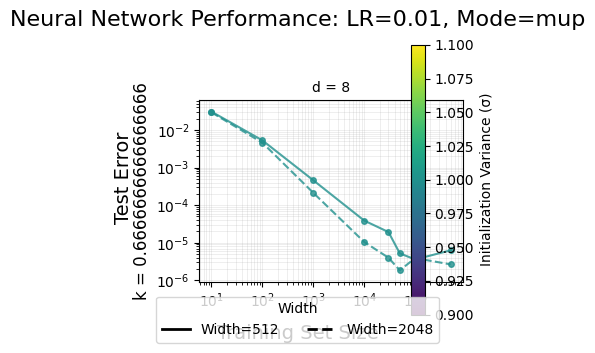

Creating grid for LR=0.01, Mode=standard


/tmp/ipykernel_1875957/489952870.py:335: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.08, 0.95, 0.92])


Saved plot to ./result_plots_NN_k_grid/grid_NN_k_factor_LR0p01_Modestandard.png


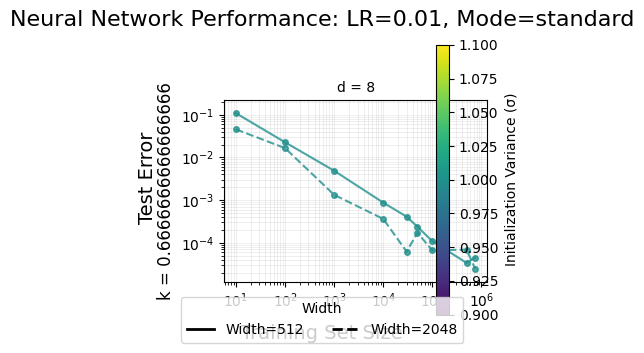

Done!


In [6]:
import os
import glob
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from matplotlib.colors import Normalize

# === Configuration ===
# Set the path to your results directory
results_dir = "/home/goring/leap/results/NN_0304_k/sweep_full_exp_20250404"

# Set to True to save plots to files
save_plots = True
output_dir = "./result_plots_NN_k_grid"

# Create output directory if needed
if save_plots:
    os.makedirs(output_dir, exist_ok=True)

def load_results(results_dir):
    """Load all result files from the specified directory."""
    result_files = []
    
    # First, try direct approach with explicit paths
    for gpu_id in range(8):
        pattern = os.path.join(results_dir, f"results_*_gpu{gpu_id}.jsonl")
        files = glob.glob(pattern)
        result_files.extend(files)
        print(f"Found {len(files)} files for GPU {gpu_id}")
    
    # If no files found, try recursive pattern
    if not result_files:
        pattern = os.path.join(results_dir, "**", "*.jsonl")
        result_files.extend(glob.glob(pattern, recursive=True))
    
    print(f"Found {len(result_files)} result files")
    if not result_files:
        print(f"No files found in {results_dir}")
        return []
    
    all_results = []
    
    for file_path in result_files:
        try:
            print(f"Processing file: {os.path.basename(file_path)}")
            valid_count = 0
            
            with open(file_path, 'r') as f:
                for line in f:
                    if line.strip():
                        try:
                            result = json.loads(line)
                            all_results.append(result)
                            valid_count += 1
                        except json.JSONDecodeError as e:
                            print(f"Error parsing JSON in {file_path}: {e}")
            
            print(f"  - Loaded {valid_count} valid results")
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    print(f"Loaded {len(all_results)} total results")
    return all_results

def process_nn_results(results):
    """Process neural network results into a DataFrame."""
    processed_data = []
    error_count = 0
    
    for result in results:
        try:
            # Check if it's a gaussian (neural network) result
            if result.get('distribution_type') != 'gaussian':
                continue
                
            # Extract basic information
            input_dim = result.get('input_dim')
            hidden_size = result.get('hidden_size')
            depth = result.get('depth')
            learning_rate = result.get('learning_rate')
            n_train = result.get('n_train')
            test_error = result.get('test_error')
            experiment_num = result.get('experiment_num', 0)
            mode = result.get('mode', 'standard')
            architecture = result.get('architecture', [])
            init_variance = result.get('init_variance', 0.1)  # Sigma value
            k_factor = result.get('k_factor')  # Get k-factor from results
            ds_depth = result.get('ds_depth')  # Get dataset neural network depth
            
            # Create architecture string
            if architecture:
                arch_str = 'x'.join(str(dim) for dim in architecture)
            else:
                arch_str = f"{hidden_size}x{depth}"
            
            # Skip if any required field is missing
            if None in [input_dim, hidden_size, depth, learning_rate, test_error, n_train, init_variance]:
                error_count += 1
                continue
            
            # Create a record
            record = {
                'input_dim': int(input_dim),
                'architecture': arch_str,
                'n_train': int(n_train),
                'test_error': float(test_error),
                'hidden_size': int(hidden_size),
                'depth': int(depth),
                'learning_rate': float(learning_rate),
                'experiment_num': int(experiment_num),
                'mode': mode,
                'init_variance': float(init_variance),  # Add sigma (initialization variance)
                'k_factor': k_factor,  # Add k-factor
                'ds_depth': ds_depth  # Add dataset network depth
            }
            
            processed_data.append(record)
        except Exception as e:
            error_count += 1
            print(f"Error processing result: {e}")
            continue
    
    print(f"Processed {len(processed_data)} valid NN results, skipped {error_count} invalid results")
    
    # Convert to DataFrame
    df = pd.DataFrame(processed_data)
    
    # Print unique values for debugging
    if not df.empty:
        print(f"Unique dimensions: {sorted(df['input_dim'].unique())}")
        print(f"Unique architectures: {sorted(df['architecture'].unique())}")
        print(f"Unique learning rates: {sorted(df['learning_rate'].unique())}")
        print(f"Unique sigma values: {sorted(df['init_variance'].unique())}")
        print(f"Unique modes: {sorted(df['mode'].unique())}")
        
        # Print k-factor information if available
        if 'k_factor' in df.columns:
            k_factors = df['k_factor'].dropna().unique()
            print(f"Unique k-factors: {sorted(k_factors)}")
        
        if 'ds_depth' in df.columns:
            ds_depths = df['ds_depth'].dropna().unique()
            print(f"Unique dataset depths: {sorted(ds_depths)}")
    
    return df

def create_grid_plots(df):
    """
    Create separate grid plots for each LR and mode combination.
    Use k-factor on the y-axis and input_dim on the x-axis.
    Within each grid, use different colors for sigma values and line styles for widths.
    """
    # Get unique values
    learning_rates = sorted(df['learning_rate'].unique())
    modes = sorted(df['mode'].unique())
    sigma_values = sorted(df['init_variance'].unique())
    
    # Get unique dimensions and k-factors for the grid
    dimensions = sorted(df['input_dim'].unique())
    
    # Check if k_factor is available in the dataframe
    if 'k_factor' not in df.columns or df['k_factor'].isna().all():
        print("Warning: k_factor not available in the data, using architectures for grid")
        k_factors = [None]  # Use None as placeholder
        use_k_factors = False
    else:
        k_factors = sorted(df['k_factor'].dropna().unique())
        use_k_factors = True
        
        # Use specific order if those values exist
        desired_order = [2/3, 1.0, 1.5]
        k_factors = [k for k in desired_order if k in k_factors] + [k for k in k_factors if k not in desired_order]
    
    # If no k_factors, fall back to architectures
    if not use_k_factors or not k_factors:
        k_factors = sorted(df['architecture'].unique())
        k_label = "Architecture"
    else:
        k_label = "k-factor"
    
    hidden_sizes = sorted(df['hidden_size'].unique())
    
    # Width line style mapping
    width_styles = {size: style for size, style in zip(
        hidden_sizes, 
        ['-', '--', '-.', ':'] * (1 + len(hidden_sizes)//4)
    )}
    
    # Color map for sigma values
    colormap = cm.viridis
    norm = Normalize(vmin=min(sigma_values), vmax=max(sigma_values))
    
    # Create separate plots for each LR and mode combination
    for lr in learning_rates:
        for mode in modes:
            print(f"Creating grid for LR={lr}, Mode={mode}")
            
            # Filter data for this LR and mode
            subset = df[(df['learning_rate'] == lr) & (df['mode'] == mode)]
            
            if subset.empty:
                print(f"  - No data for this combination")
                continue
            
            # Create a grid of plots
            fig, axes = plt.subplots(
                nrows=len(k_factors),
                ncols=len(dimensions),
                figsize=(len(dimensions)*4, len(k_factors)*3.5),
                sharex=True,
                sharey=True,
                squeeze=False
            )
            
            # Set the figure title
            fig.suptitle(f'Neural Network Performance: LR={lr}, Mode={mode}', fontsize=16)
            
            # Add common x and y labels
            fig.text(0.5, 0.04, 'Training Set Size', ha='center', fontsize=14)
            fig.text(0.04, 0.5, 'Test Error', va='center', rotation='vertical', fontsize=14)
            
            # Calculate global min and max for y-axis
            min_error = subset['test_error'].min() * 0.5
            max_error = subset['test_error'].max() * 2.0
            
            # Create legend elements for widths
            width_legend_elements = []
            
            # Fill in each cell of the grid
            for i, k_val in enumerate(k_factors):
                for j, dim in enumerate(dimensions):
                    ax = axes[i, j]
                    
                    # Set cell title
                    if i == 0:  # Top row gets dimension
                        ax.set_title(f'd = {dim}', fontsize=10)
                    
                    if j == 0:  # First column gets k-factor
                        if use_k_factors:
                            ax.set_ylabel(f'k = {k_val}', fontsize=12)
                        else:
                            ax.set_ylabel(f'Arch: {k_val}', fontsize=12)
                    
                    # Filter data for this cell
                    if use_k_factors:
                        cell_data = subset[(subset['input_dim'] == dim) & (subset['k_factor'] == k_val)]
                    else:
                        cell_data = subset[(subset['input_dim'] == dim) & (subset['architecture'] == k_val)]
                    
                    if cell_data.empty:
                        ax.text(0.5, 0.5, 'No Data', 
                               ha='center', va='center', transform=ax.transAxes)
                        continue
                    
                    # Log scales
                    ax.set_xscale('log')
                    ax.set_yscale('log')
                    
                    # Plot lines for each combination of sigma and width
                    for sigma in sigma_values:
                        for h_size in hidden_sizes:
                            # Get data for this combination
                            point_data = cell_data[
                                (cell_data['init_variance'] == sigma) & 
                                (cell_data['hidden_size'] == h_size)
                            ]
                            
                            if point_data.empty:
                                continue
                            
                            # Handle duplicates by averaging
                            point_data = point_data.groupby('n_train')['test_error'].mean().reset_index()
                            
                            # Sort by n_train for proper line plotting
                            point_data = point_data.sort_values('n_train')
                            
                            if len(point_data) <= 1:
                                continue  # Need at least two points to draw a line
                            
                            # Get color based on sigma value
                            color = colormap(norm(sigma))
                            
                            # Get line style based on width
                            linestyle = width_styles.get(h_size, '-')
                            
                            # Plot data points and line
                            line, = ax.plot(
                                point_data['n_train'],
                                point_data['test_error'],
                                color=color,
                                linestyle=linestyle,
                                marker='o',
                                markersize=4,
                                alpha=0.8,
                                label=f'σ={sigma}, W={h_size}'
                            )
                            
                            # Add width to legend elements once per combination
                            if i == 0 and j == 0:
                                # Only add unique elements
                                if f'Width={h_size}' not in [le.get_label() for le in width_legend_elements]:
                                    width_legend_elements.append(
                                        Line2D([0], [0], color='black', linestyle=linestyle, lw=2, 
                                               label=f'Width={h_size}')
                                    )
                    
                    # Set the y-axis limits
                    if min_error > 0 and max_error > 0:
                        ax.set_ylim(min_error, max_error)
                    
                    # Add grid
                    ax.grid(True, which='both', linestyle='-', linewidth=0.5, alpha=0.3)
            
            # Add colorbar for sigma values
            sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
            sm.set_array([])
            cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), label='Initialization Variance (σ)')
            
            # Add width legend
            if width_legend_elements:
                fig.legend(
                    handles=width_legend_elements,
                    loc='lower center',
                    ncol=min(4, len(width_legend_elements)),
                    bbox_to_anchor=(0.5, 0.01),
                    fontsize=10,
                    title="Width"
                )
            
            # Adjust layout
            plt.tight_layout(rect=[0.05, 0.08, 0.95, 0.92])
            
            # Save figure if requested
            if save_plots:
                lr_str = str(lr).replace('.', 'p')
                grid_type = "k_factor" if use_k_factors else "arch"
                filename = f'grid_NN_{grid_type}_LR{lr_str}_Mode{mode}.png'
                save_path = os.path.join(output_dir, filename)
                plt.savefig(save_path, dpi=300, bbox_inches='tight')
                print(f"Saved plot to {save_path}")
            
            plt.show()

def main():
    print("Starting neural network grid plot creation with k-factor on y-axis...")
    
    # Load results
    results = load_results(results_dir)
    
    if not results:
        print("No results were loaded. Please check paths and file formats.")
        return
    
    # Process results
    df = process_nn_results(results)
    
    if len(df) == 0:
        print("No valid neural network data entries after processing.")
        return
    
    # Print summary statistics
    print(f"\nProcessed {len(df)} data points with:")
    print(f"  - {df['learning_rate'].nunique()} learning rates: {sorted(df['learning_rate'].unique())}")
    print(f"  - {df['hidden_size'].nunique()} hidden sizes: {sorted(df['hidden_size'].unique())}")
    print(f"  - {df['depth'].nunique()} depths: {sorted(df['depth'].unique())}")
    print(f"  - {df['input_dim'].nunique()} dimensions: {sorted(df['input_dim'].unique())}")
    print(f"  - {df['architecture'].nunique()} architectures: {sorted(df['architecture'].unique())}")
    print(f"  - {df['mode'].nunique()} modes: {sorted(df['mode'].unique())}")
    print(f"  - {df['init_variance'].nunique()} sigma values: {sorted(df['init_variance'].unique())}")
    
    # Print k-factor information if available
    if 'k_factor' in df.columns:
        print(f"  - {df['k_factor'].nunique()} k-factors: {sorted(df['k_factor'].dropna().unique())}")
    
    if 'ds_depth' in df.columns:
        print(f"  - {df['ds_depth'].nunique()} dataset depths: {sorted(df['ds_depth'].dropna().unique())}")
    
    # Create the grid plots
    create_grid_plots(df)
    
    print("Done!")

if __name__ == "__main__":
    main()